# Data modelling and model building

Building data models to predict pollution

## Data loading and preparation

In [3]:
import pandas as pd
# Load the data
data = pd.read_csv('../Combined data/combined_data_hourly_2023.csv')

data = data.iloc[:, :11].join(data[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data['Weekday'] = data['Weekday'].astype('category')
data['Hour'] = data['Hour'].astype('category')

print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             8758 non-null   object 
 1   Hour                8758 non-null   int64  
 2   NO2_ppb             8649 non-null   float64
 3   NOx_ppb             8497 non-null   float64
 4   Temp_dry            8757 non-null   float64
 5   Humidity            8757 non-null   float64
 6   wind_speed          8757 non-null   float64
 7   Pressure            8757 non-null   float64
 8   visibility          8758 non-null   float64
 9   Wind_dir            8757 non-null   float64
 10  Traffic east        8758 non-null   float64
 11  Traffic north-east  8758 non-null   float64
 12  Traffic south-east  8758 non-null   float64
 13  Traffic Hvidovre    8758 non-null   float64
 14  Traffic north-west  8758 non-null   float64
 15  Traffic south-west  8758 non-null   float64
 16  Traffi

In [4]:
# Ensure the 'Wind_dir' column is numeric before categorization
data['Wind_dir'] = pd.to_numeric(data['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data['Wind_dir'] = data['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data['Wind_dir'] = data['Wind_dir'].astype('category')

In [5]:
# show the levels of the 'Weekday' column
print(data['Weekday'].cat.categories)
print(data['Hour'].cat.categories)
print(data['Wind_dir'].cat.categories)
data.describe()

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')
Index(['E', 'N', 'NE', 'NW', 'S', 'SE', 'SW', 'W'], dtype='object')


,NO2_ppb,NOx_ppb,Temp_dry,Humidity,wind_speed,Pressure,visibility,Traffic east,Traffic north-east,Traffic south-east,Traffic Hvidovre,Traffic north-west,Traffic south-west,Traffic west
count,8649.000000,8497.000000,8757.000000,8757.000000,8757.000000,8757.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000
mean,4.240136,5.212444,10.020416,77.146538,5.121321,1012.070007,39579.653269,12.649145,18.348691,9.544604,13.522538,16.436796,8.841485,10.464269
std,3.929058,6.871200,6.674464,14.628129,2.663858,12.049569,19987.508255,11.450062,16.583565,12.718775,14.229252,16.064491,6.377068,8.283016
min,0.020725,-0.076125,-6.650000,26.666667,0.000000,849.883333,50.000000,0.000000,0.000000,0.000000,0.000000,0.920000,0.920000,0.920000
25%,1.757351,2.076923,4.650000,68.333333,3.100000,1003.816667,24666.666667,3.950000,3.810000,2.150000,3.310000,4.820000,4.300000,4.770000
50%,3.018082,3.372438,9.200000,80.333333,4.766667,1012.916667,40833.333333,9.670000,12.880000,3.850000,8.670000,10.160000,7.160000,7.440000
75%,5.207296,5.761782,16.066667,88.500000,6.783333,1020.716667,55833.333333,15.440000,27.940000,10.220000,16.185000,19.740000,10.630000,13.820000
max,32.357715,93.195720,26.166667,100.000000,18.000000,1041.583333,75000.000000,61.760000,69.480000,60.660000,69.480000,66.170000,31.980000,43.010000


Missing values

Missing values count in each column:
Weekday                 0
Hour                    0
NO2_ppb               109
NOx_ppb               261
Temp_dry                1
Humidity                1
wind_speed              1
Pressure                1
visibility              0
Wind_dir                0
Traffic east            0
Traffic north-east      0
Traffic south-east      0
Traffic Hvidovre        0
Traffic north-west      0
Traffic south-west      0
Traffic west            0
dtype: int64


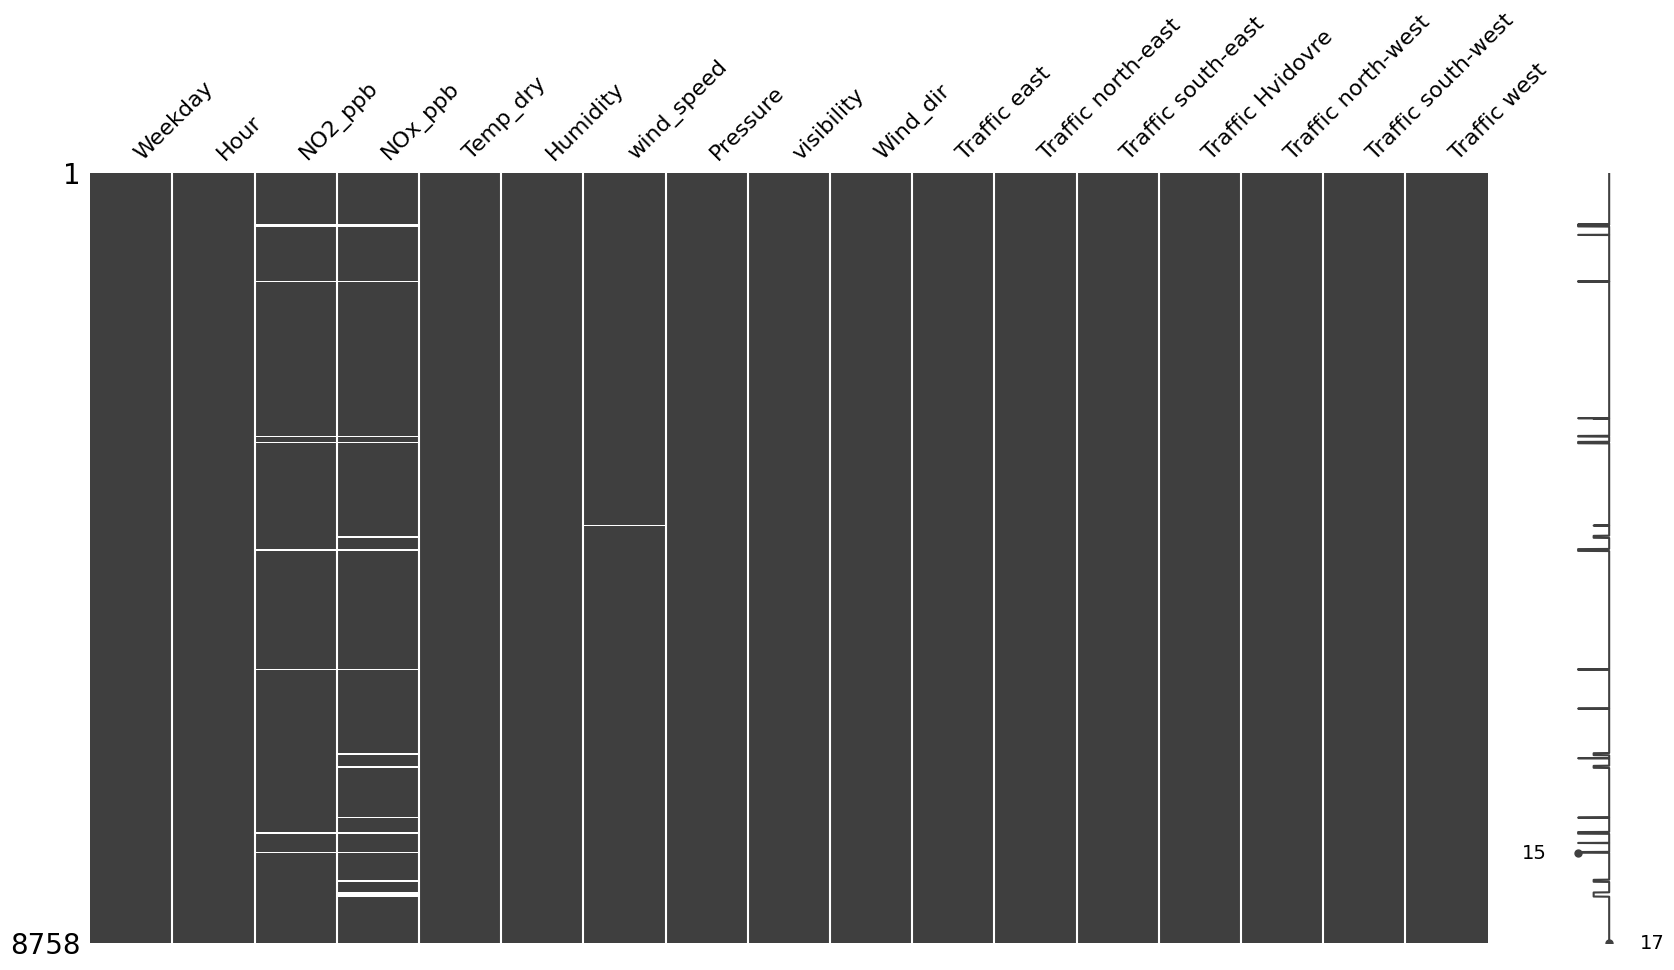

Data after dropping rows with missing values:
Weekday               0
Hour                  0
NO2_ppb               0
NOx_ppb               0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64


C:\Users\whart\AppData\Local\Temp\ipykernel_6000\1868761441.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NO2_ppb'].fillna(data['NO2_ppb'].mean(), inplace=True)
C:\Users\whart\AppData\Local\Temp\ipykernel_6000\1868761441.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [6]:
# Count rows with missing values
missing_values_count = data.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data['NO2_ppb'].fillna(data['NO2_ppb'].mean(), inplace=True)
data['NOx_ppb'].fillna(data['NOx_ppb'].mean(), inplace=True)
data['Temp_dry'].fillna(data['Temp_dry'].mean(), inplace=True)
data['wind_speed'].fillna(data['wind_speed'].mean(), inplace=True)
data['Pressure'].fillna(data['Pressure'].mean(), inplace=True)
data['visibility'].fillna(data['visibility'].mean(), inplace=True)
data['Humidity'].fillna(data['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Consider using KNN to impute missing values instead.

In [7]:
# Transform the categorical variables into dummy variables
data = pd.get_dummies(data, drop_first=True)
print(data.head())

    NO2_ppb    NOx_ppb   Temp_dry   Humidity  wind_speed     Pressure  \
0  9.609539  14.333718   8.083333  98.500000    5.600000  1000.050000   
1  2.431203   2.601390   9.516667  97.500000    6.600000   999.616667   
2  1.794863   1.888760  10.200000  95.000000   10.633333   999.666667   
3  1.286549   1.169177  10.033333  95.666667   10.300000   999.866667   
4  1.020709   0.850521  10.166667  95.000000   10.300000  1000.300000   

    visibility  Traffic east  Traffic north-east  Traffic south-east  ...  \
0  3600.000000          3.73                8.40                0.93  ...   
1  4250.000000          1.87                5.60                0.93  ...   
2  4550.000000          0.93                3.73                0.93  ...   
3  3566.666667          0.00                2.80                0.00  ...   
4  3650.000000          0.00                0.93                0.00  ...   

   Hour_21  Hour_22  Hour_23  Wind_dir_N  Wind_dir_NE  Wind_dir_NW  \
0    False    False    False

Splitting into training and testing set.

In [8]:
# X and Y. X should be all variables except NO2_ppb, and Y should be NO2_ppb
X = data.drop(columns=['NO2_ppb', 'NOx_ppb'])
y = data['NO2_ppb']

# Split the data into training and testing sets
split_index = int(len(X) * 0.8)

# Chronological split, which is possible as the data is already in order
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

Data visualization

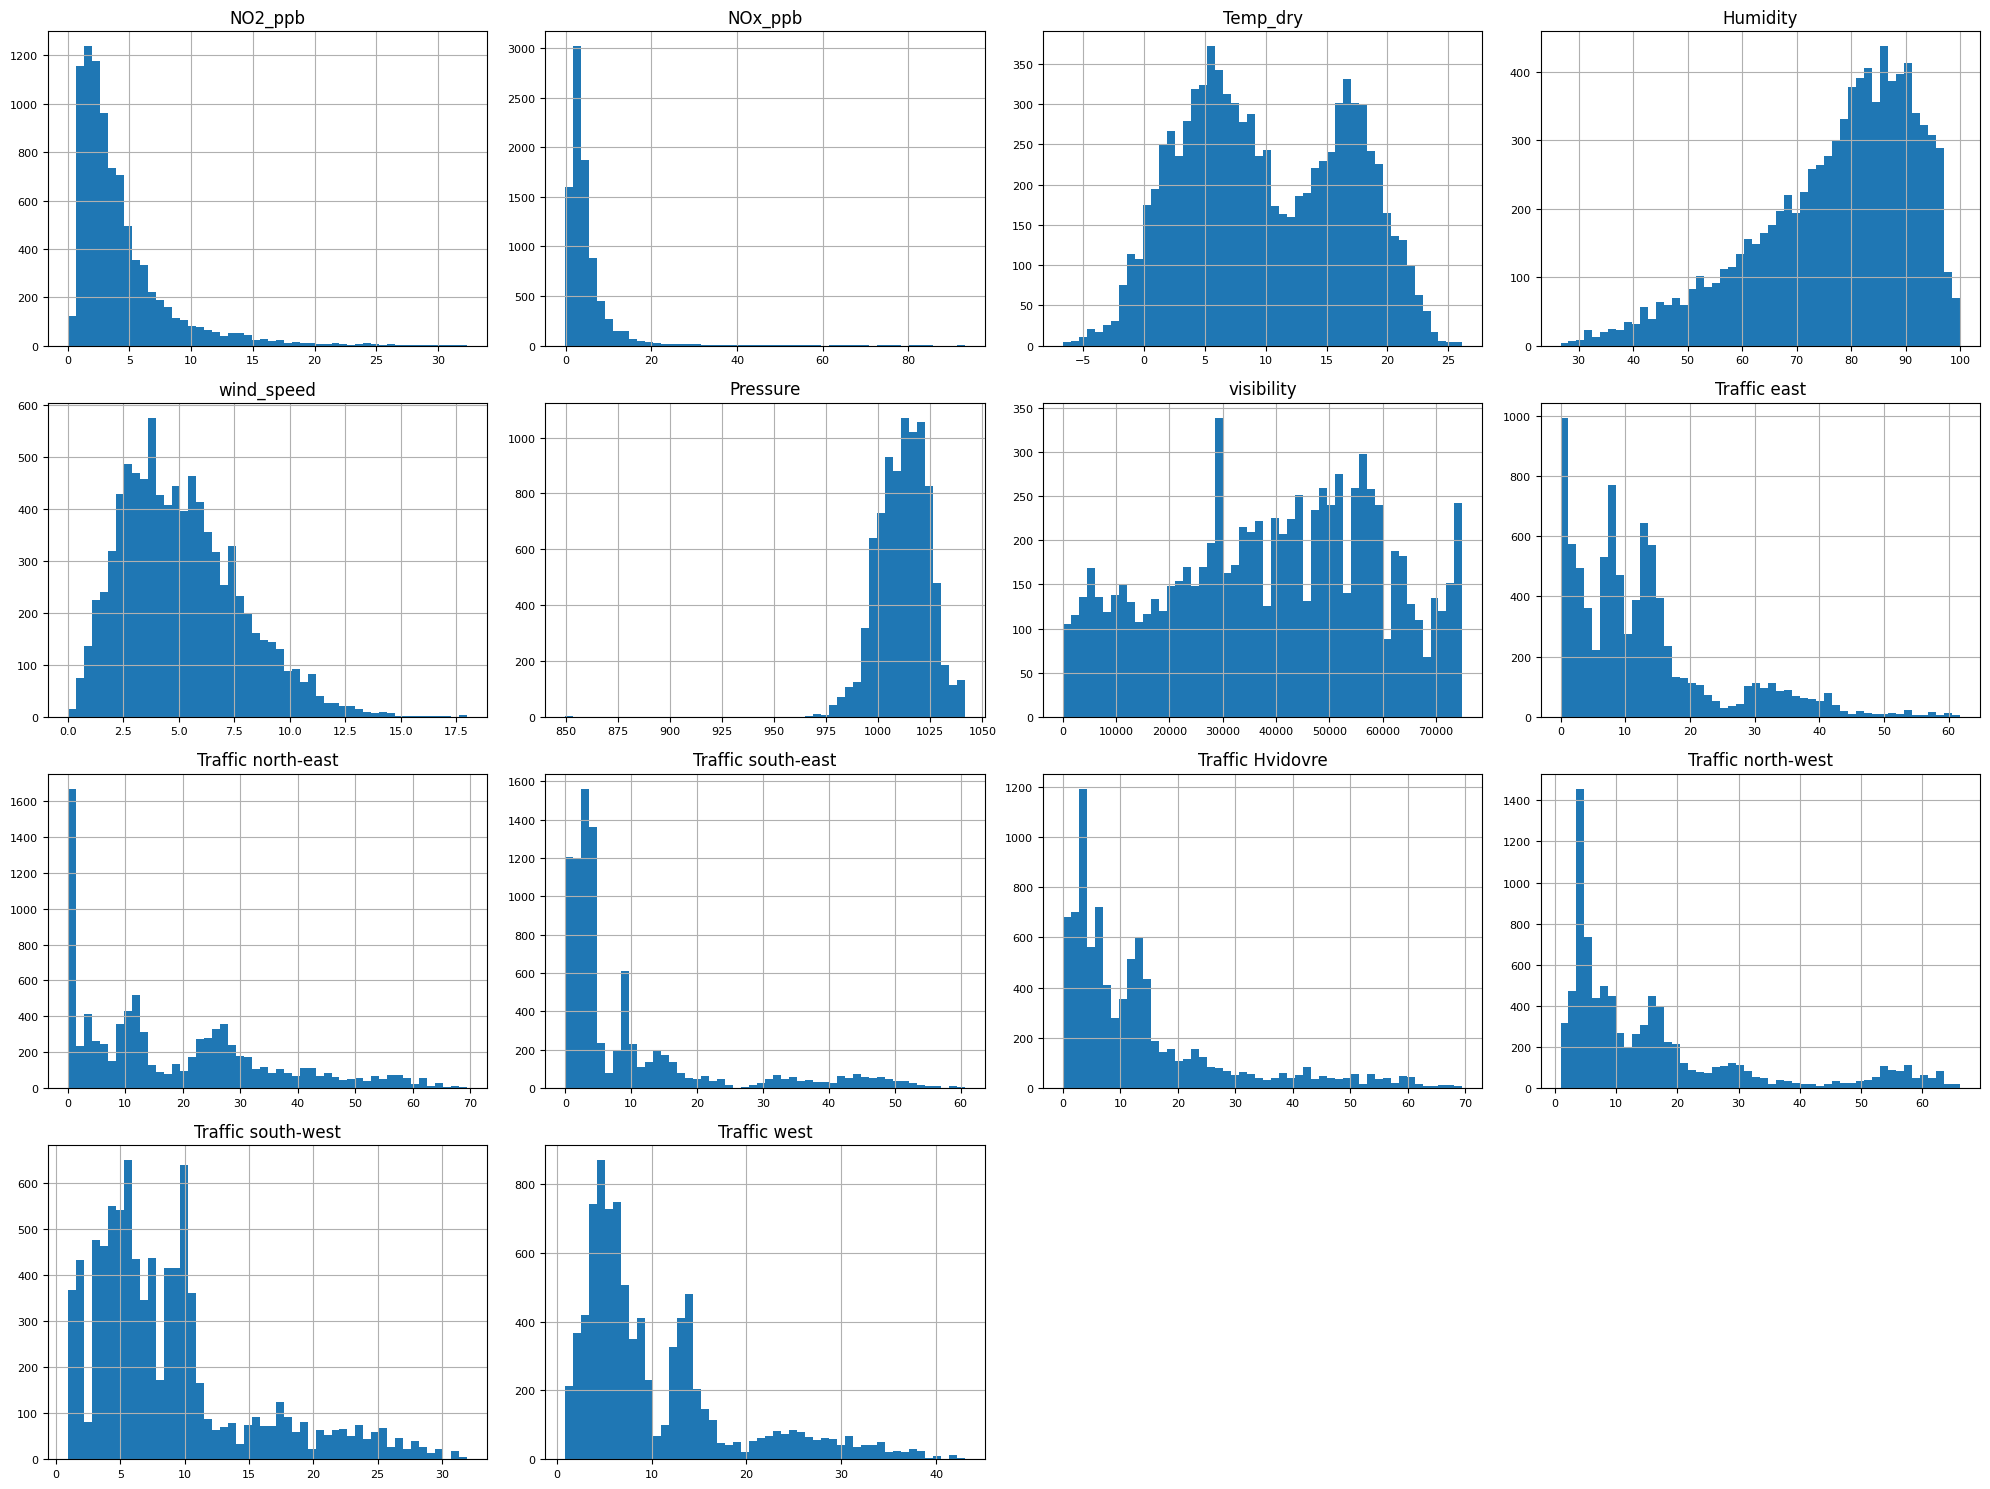

In [7]:
# Visualize the numeric data with histograms
data.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout()

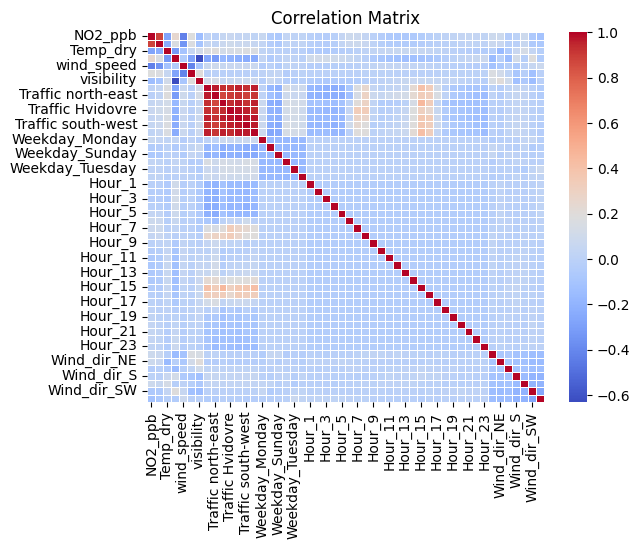

In [8]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

As it can be seen, there are a lot of multicollinearity to be found among the different traffic variables, which can prove to be a problem for the final model.

## Modelling

### Linear regression

In [9]:
from sklearn.linear_model import LinearRegression    # Requires package scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

import statsmodels.api as sm

# Add a constant to the model (intercept)
X_train_const = sm.add_constant(X_train)

# Fit the model using statsmodels
ols_model = sm.OLS(y_train, X_train_const.astype(float)).fit()

# Print the coefficients and their p-values
print(ols_model.summary())

Mean Squared Error: 9.221375944414435
                            OLS Regression Results                            
Dep. Variable:                NO2_ppb   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     93.97
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        20:17:41   Log-Likelihood:                -17718.
No. Observations:                7006   AIC:                         3.553e+04
Df Residuals:                    6957   BIC:                         3.587e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

### Linear Stepwise Regression

### KNN

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define pipeline with scaling + KNN model
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Since KNN is distance-based the variables will be standard scaled
    ('knn', KNeighborsRegressor())
])

# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 51))  # test k = 1 to 50
}

# Grid search with cross-validation (use TimeSeriesSplit if you want)
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best k:", grid_search.best_params_['knn__n_neighbors'])
print(f"Test MSE: {mse:.2f}")

Best k: 24
Test MSE: 13.57


### PLS

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best n_components: 12
    n_components  mean_test_score  mean_test_mse
11            12         -9.35063        9.35063


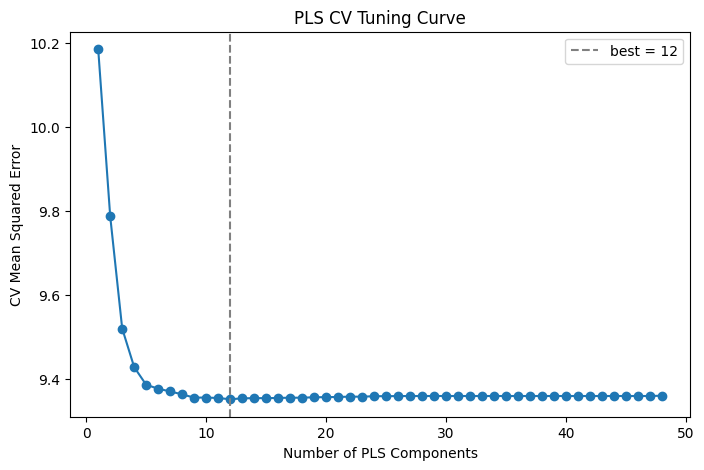

PLS Regression MSE:  9.2110


In [46]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

#Fixed seed
np.random.seed(123)

#Build a pipeline: scale → PLS
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pls",    PLSRegression())
])

#Param grid: tune n_components from 1 up to 100
#(Caret’s tuneLength = 100)
max_comps = min(100, X_train.shape[1])
param_grid = {
    "pls__n_components": list(range(1, max_comps + 1))
}

#10-fold CV with shuffling+seed to mimic trainControl(method="cv", number=10)
cv = KFold(n_splits=10, shuffle=True, random_state=123)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# 6) Fit
grid.fit(X_train, y_train)

# 7) Best number of components
best_n = grid.best_params_["pls__n_components"]
print("Best n_components:", best_n)

# 8) Tabulate the MSE for each n_components
#    caret’s PLS$results → grid.cv_results_
results = pd.DataFrame(grid.cv_results_)
results = results[["param_pls__n_components", "mean_test_score"]].copy()
results["mean_test_mse"] = -results["mean_test_score"]
results = results.rename(columns={"param_pls__n_components": "n_components"})
print(results[results.n_components == best_n])

# 9) Plot test-set MSE vs n_components
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results.n_components, results.mean_test_mse, marker="o")
plt.axvline(best_n, color="gray", linestyle="--", label=f"best = {best_n}")
plt.xlabel("Number of PLS Components")
plt.ylabel("CV Mean Squared Error")
plt.title("PLS CV Tuning Curve")
plt.legend()
plt.show()

#Extracting the best pipeline
best_pls = grid.best_estimator_
y_pred_pls = best_pls.predict(X_test)

#MSE result on the test set
pls_mse  = mean_squared_error(y_test, y_pred_pls)

print(f"PLS Regression MSE:  {pls_mse:.4f}")

### SVM

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Create the SVM regression model
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_y_pred = svm_model.predict(X_test)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_y_pred)
print(f"SVM Regression Mean Squared Error: {svm_mse}")

SVM Regression Mean Squared Error: 18.392474696155407


### Random forrest

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_y_pred)
print(f"Random Forest Mean Squared Error: {rf_mse}")

Random Forest Mean Squared Error: 8.343084463929678


### Random forrest with parameter tuning

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, KFold

#*Note: The models are quite large due to the expansive grid search (Takes about 30 min to run ATM)

#Setting up training data
n_features = X_train.shape[1]

#mtry grid
mtry_grid = [
    int(np.floor(n_features * p))
    for p in [0.05, 0.10, 0.15, 0.25, 0.30,
              0.35, 0.40, 0.45, 0.50, 0.55,
              0.60, 0.65, 0.70, 0.75, 0.80, 0.85]
]

#Rest of parameter grid
param_grid = {
    "max_features":   mtry_grid,
    "min_samples_leaf": list(range(1, 21)) #Min nodes from R called leafs here
}

#10-fold CV control (shuffled for extra randomness):
cv = KFold(n_splits=10, shuffle=True, random_state=123)

#There follows two models, just pick the one with the lowest CV validated MSE and test that model on the test set

# ——————————————
# A) “variance” splitrule → RandomForestRegressor
# ——————————————
rf = RandomForestRegressor(
    criterion="squared_error",
    random_state=123,
    n_jobs=-1
)
rf_search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
rf_search.fit(X_train, y_train)

print("RF (variance) best params:", rf_search.best_params_)
print("RF CV MSE:", -rf_search.best_score_)

# ————————————————————
# B) “extratrees” splitrule → ExtraTreesRegressor
# ————————————————————
et = ExtraTreesRegressor(
    random_state=123,
    n_jobs=-1
)
et_search = GridSearchCV(
    et,
    param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
et_search.fit(X_train, y_train)

print("ET (extratrees) best params:", et_search.best_params_)
print("ET CV MSE:", -et_search.best_score_)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
RF (variance) best params: {'max_features': 19, 'min_samples_leaf': 1}
RF CV MSE: 5.130862166733776
Fitting 10 folds for each of 320 candidates, totalling 3200 fits
ET (extratrees) best params: {'max_features': 31, 'min_samples_leaf': 1}
ET CV MSE: 4.847461235184476


In [13]:
#Import mean_squared_error:
from sklearn.metrics import mean_squared_error


Random Forest Mean Squared Error: 7.79417710687343
Random Forest (extra trees) Mean Squared Error: 7.918979853345743


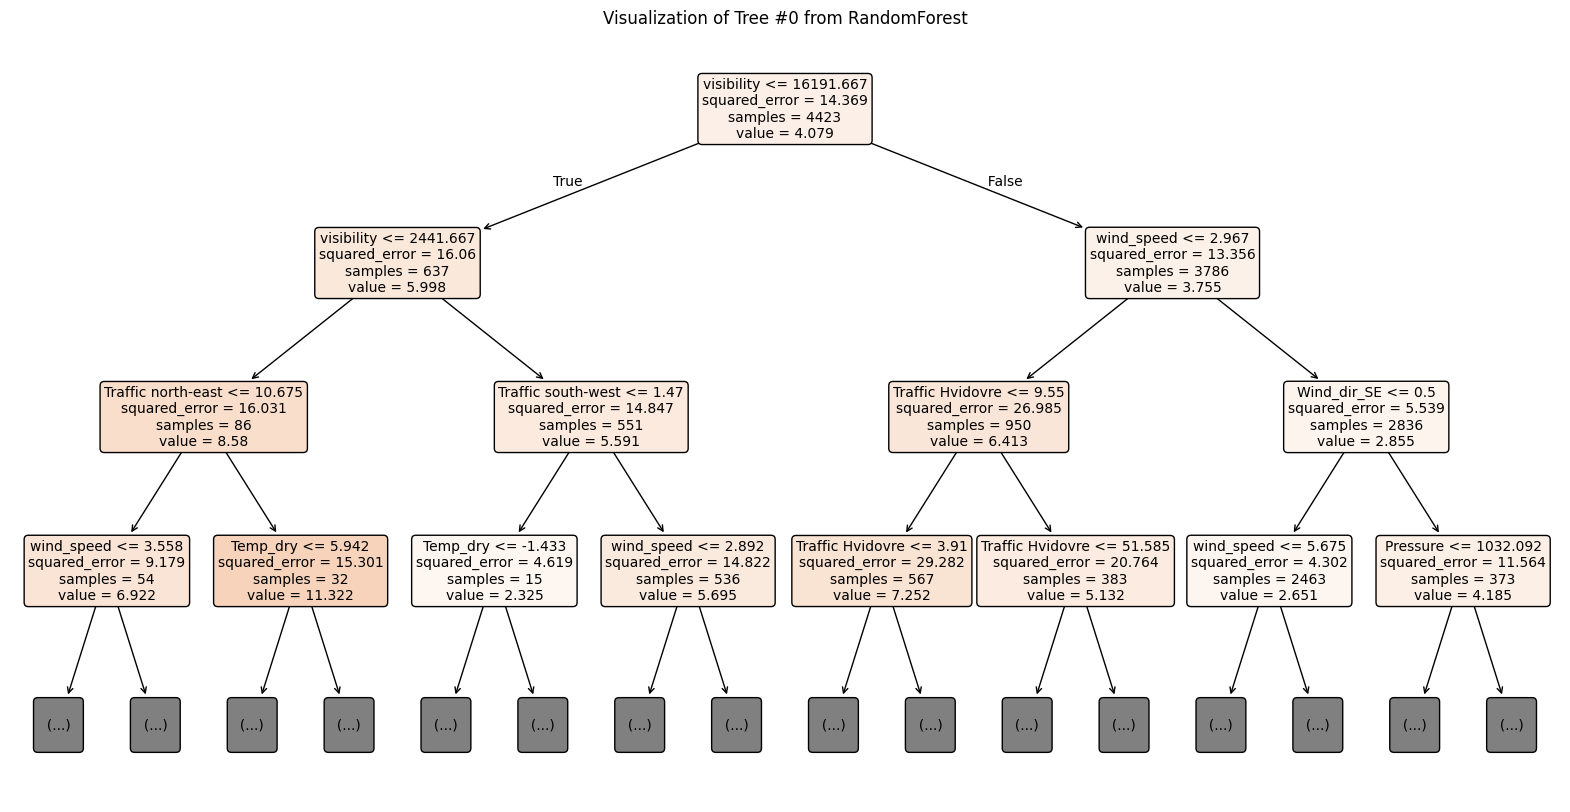

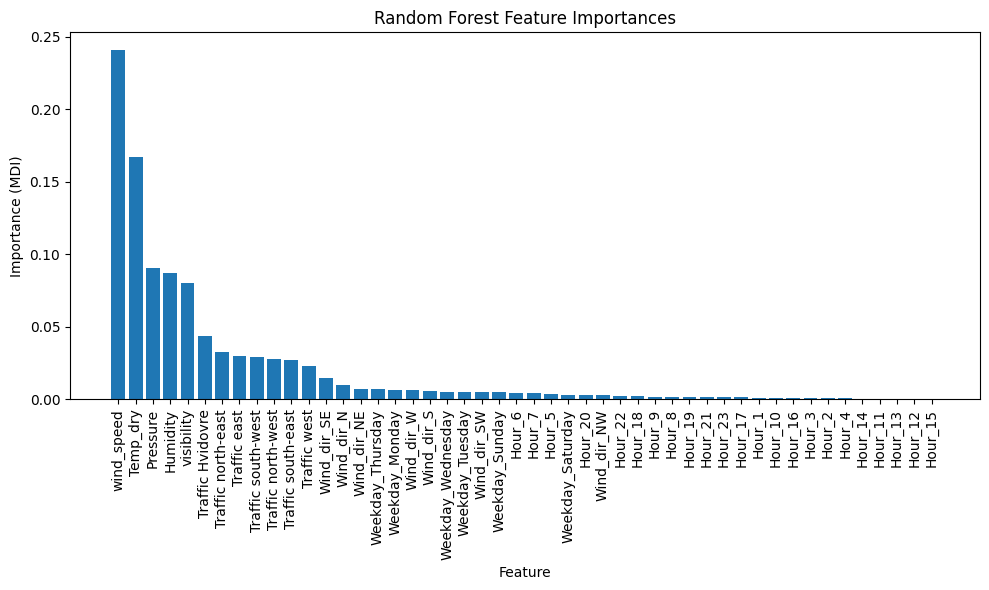

In [89]:
#Rf best
RF_best_model = rf_search.best_estimator_
RF_pred = RF_best_model.predict(X_test)

RF_mse = mean_squared_error(y_test, RF_pred)
print(f"Random Forest Mean Squared Error: {RF_mse}")

#ET best
ET_best_model = et_search.best_estimator_
ET_pred = ET_best_model.predict(X_test)

ET_mse = mean_squared_error(y_test, ET_pred)
print(f"Random Forest (extra trees) Mean Squared Error: {ET_mse}")

#Plotting single decision tree from the best RF model
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

single_tree = RF_best_model.estimators_[0]

plt.figure(figsize=(20, 10))

plot_tree(
    single_tree,
    feature_names=X_train.columns,  
    filled=True,
    rounded=True,
    max_depth=3,                   
    fontsize=10
)

plt.title("Visualization of Tree #0 from RandomForest")
plt.show()

#Variable importance of the RF model
import numpy as np
import matplotlib.pyplot as plt

# Extract importances and feature names
importances = RF_best_model.feature_importances_
feature_names = X_train.columns 

# Sort by importance (descending)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features    = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(
    range(len(sorted_importances)),
    sorted_importances,
    align="center"
)
plt.xticks(
    range(len(sorted_importances)),
    sorted_features,
    rotation=90
)
plt.xlabel("Feature")
plt.ylabel("Importance (MDI)")
plt.tight_layout()
plt.show()

C:\Users\whart\AppData\Local\Temp\ipykernel_6000\4087239042.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=manual_start_date, periods=len(y_test), freq='H')


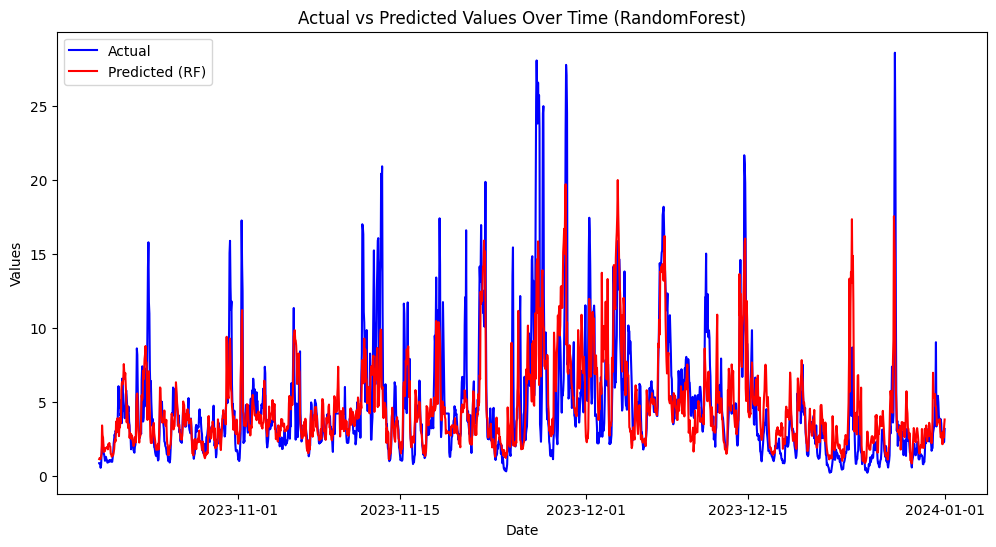

In [27]:
# Plotting Actual vs Predicted values for RandomForest
manual_start_date = '2023-10-20 00:00'  #Start of test set
dates = pd.date_range(start=manual_start_date, periods=len(y_test), freq='H')

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual', color='blue')
plt.plot(dates, RF_pred, label='Predicted (RF)', color='red')
plt.title('Actual vs Predicted Values Over Time (RandomForest)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

### Forecasting with RF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

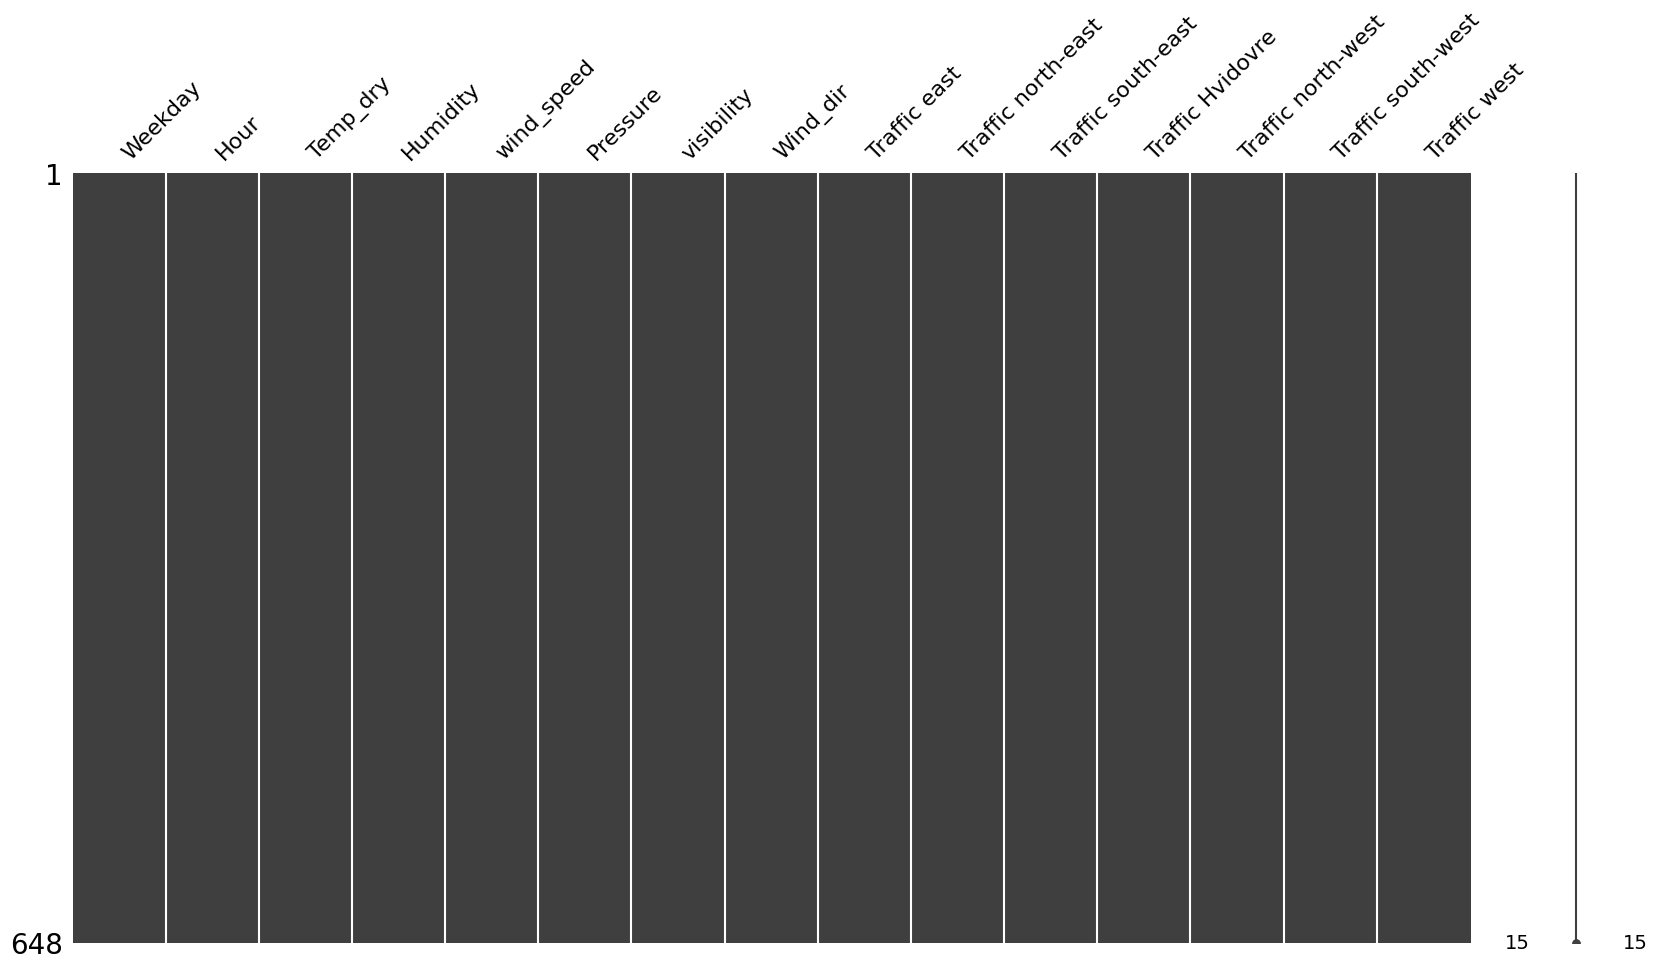

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      3.391251   
1      12.2        78         4.0    1021.9       21420      2.543438   
2      11.8        71         1.4    1021.9       12680      2.543438   
3      11.4        65         1.1    1022.1        4420      1.695626   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.847813            2.543438          2.543438   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1774284752.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data2['Temp_dry'].fillna(data2['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1774284752.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [79]:
#DATA PREP
import pandas as pd
# Load the data
data2 = pd.read_excel('../Combined data/Forecast May 2025.xlsx')

data2 = data2.iloc[:, :9].join(data2[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data2.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data2.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data2.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data2['Weekday'] = data2['Weekday'].astype('category')
data2['Hour'] = data2['Hour'].astype('category')

print(data2.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data2['Wind_dir'] = pd.to_numeric(data2['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data2['Wind_dir'] = data2['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data2['Wind_dir'] = data2['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data2.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data2, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data2['Temp_dry'].fillna(data2['Temp_dry'].mean(), inplace=True)
data2['wind_speed'].fillna(data2['wind_speed'].mean(), inplace=True)
data2['Pressure'].fillna(data2['Pressure'].mean(), inplace=True)
data2['visibility'].fillna(data2['visibility'].mean(), inplace=True)
data2['Humidity'].fillna(data2['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data2.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data2 = pd.get_dummies(data2, drop_first=True)
print(data2.head())

[2.0027065  4.36918478 7.99397732 7.31943479 6.08821961 5.19732915
 3.80322028 2.3746971  2.2197569  1.49544105 1.34692713 1.27149894
 1.60225493 1.78210752 2.0058108  2.04707752 2.04927032 2.05208379
 2.05585607 2.35397026 2.96577627 2.39561214 2.36741945 2.5472862
 2.30294361 1.36828444 1.10230892 1.21858031 1.33228232 1.72021312
 1.71524423 1.34612225 1.1088232  1.03230984 1.59055171 1.39423768
 1.27084643 1.18955847 1.12226018 1.1001228  1.02674005 1.11742092
 1.36469186 1.7893929  1.90695637 1.52349336 1.53849823 1.53401854
 1.28971103 1.35459354 1.11325036 1.29227233 1.10963982 1.30221908
 1.32493708 1.37452496 1.52589836 1.43006037 1.31055766 1.30463623
 0.98438808 1.11635269 1.07064606 1.39182334 1.44799508 1.47465684
 1.94478907 1.62373488 1.42872981 1.56599092 1.30793033 1.21895781
 1.5124472  1.12334666 0.89384704 1.2378608  1.29307707 1.40068671
 1.11495257 1.21338109 1.36624858 1.49373544 1.59797108 1.58601065
 1.4393701  1.45843863 1.42352984 1.40260353 1.462732   1.57743

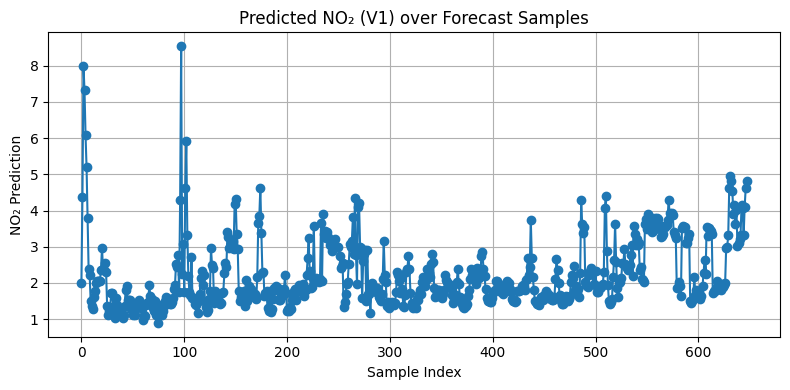

In [83]:
#Forecast with RF
preds_V1 = RF_best_model.predict(data2)
print(preds_V1)

plt.figure(figsize=(8,4))
plt.plot(preds_V1, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V1) over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()


### Forecast RF (Decreased traffic by 50%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

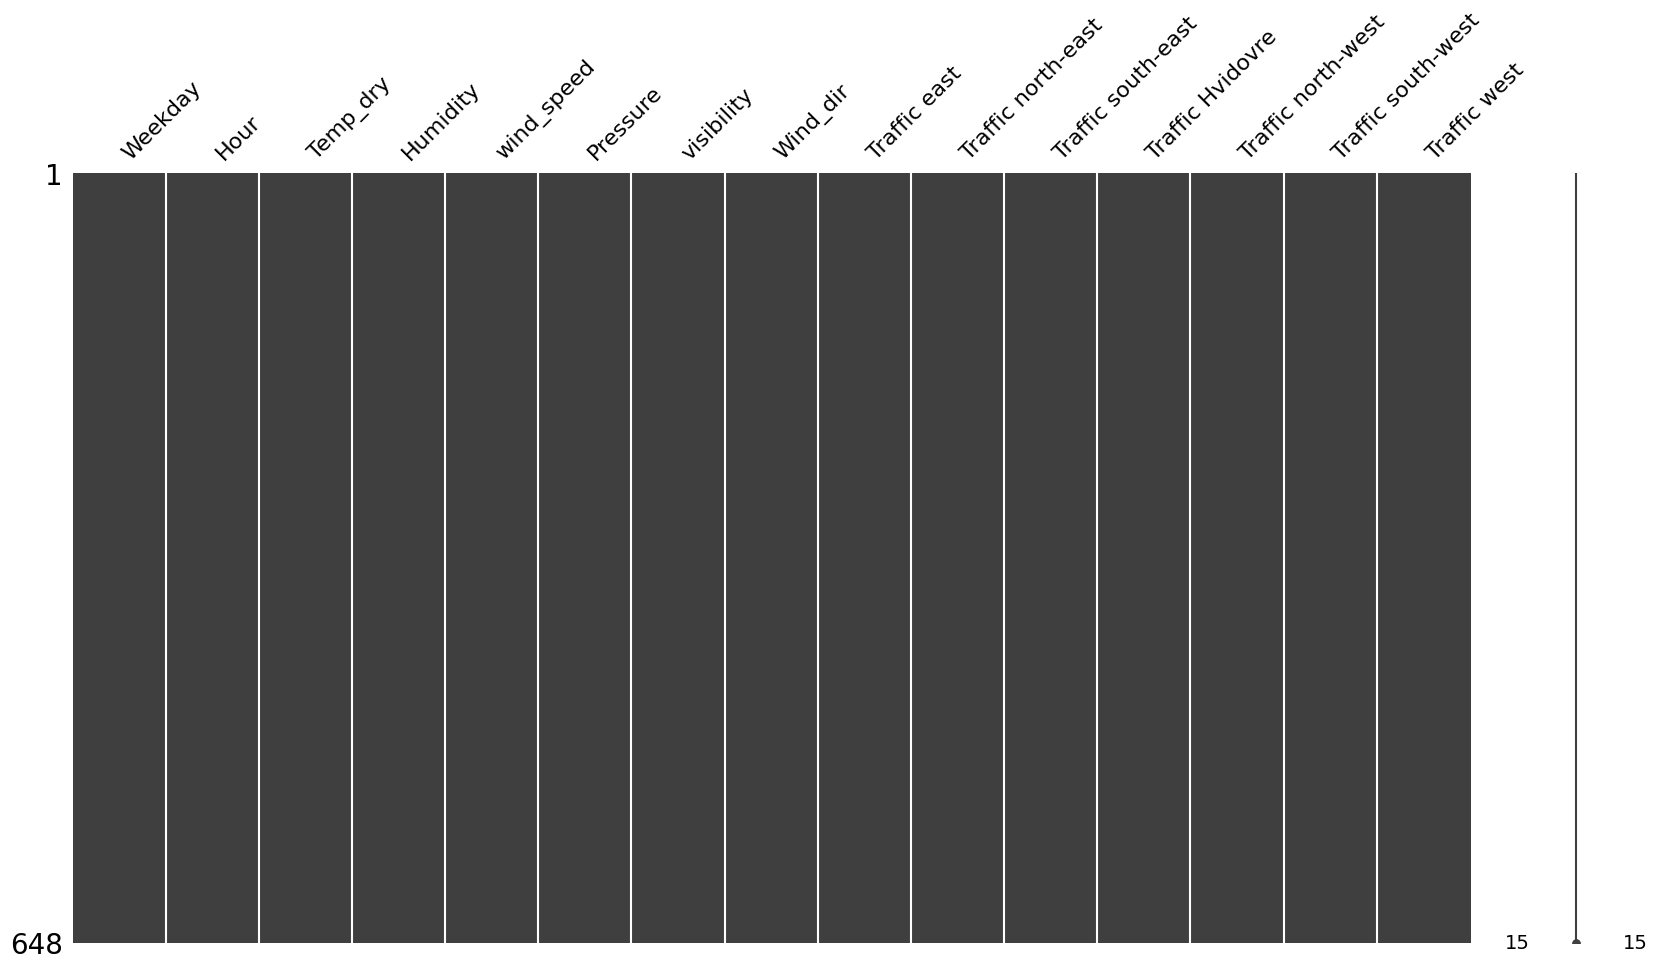

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      1.695626   
1      12.2        78         4.0    1021.9       21420      1.271719   
2      11.8        71         1.4    1021.9       12680      1.271719   
3      11.4        65         1.1    1022.1        4420      0.847813   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.423906            1.271719          1.271719   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\82764013.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data3['Temp_dry'].fillna(data3['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\82764013.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [84]:
#DATA PREP
import pandas as pd
# Load the data
data3 = pd.read_excel('../Combined data/Forecast May 2025 (decreased traffic).xlsx')

data3 = data3.iloc[:, :9].join(data3[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data3.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data3.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data3.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data3['Weekday'] = data3['Weekday'].astype('category')
data3['Hour'] = data3['Hour'].astype('category')

print(data3.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data3['Wind_dir'] = pd.to_numeric(data3['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data3['Wind_dir'] = data3['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data3['Wind_dir'] = data3['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data3.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data3, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data3['Temp_dry'].fillna(data3['Temp_dry'].mean(), inplace=True)
data3['wind_speed'].fillna(data3['wind_speed'].mean(), inplace=True)
data3['Pressure'].fillna(data3['Pressure'].mean(), inplace=True)
data3['visibility'].fillna(data3['visibility'].mean(), inplace=True)
data3['Humidity'].fillna(data3['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data3.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data3 = pd.get_dummies(data3, drop_first=True)
print(data3.head())

[2.2182737  4.55484056 7.21398321 6.92438305 6.16580942 5.15151739
 3.25111443 2.34696301 2.14363603 2.16569966 1.88388719 1.79549865
 2.2300048  2.26967702 1.61509439 1.97705738 1.96743403 1.9808207
 2.15137509 2.32732894 2.94639768 2.65506601 2.64929268 2.79534759
 2.57260925 1.5924301  1.17966651 1.25020216 1.25592613 1.52224072
 1.39665551 1.70258632 1.24821288 1.40577416 1.32510251 1.38671259
 1.61253816 1.61969276 1.12770558 1.11269834 1.04652519 1.56899384
 1.65871897 1.76052716 1.8934244  1.52739788 1.43319495 1.61792264
 1.29252556 1.28397373 1.10317293 1.3539215  1.11956291 1.27907836
 1.26449346 1.27980764 1.50632246 1.35671836 1.37845997 1.31954346
 1.37212199 1.2977962  1.23413623 1.1574377  1.23756433 1.20024942
 1.28587587 1.34311049 1.23793316 1.73239938 1.28528151 1.2735414
 1.4135679  0.95674588 0.93603349 1.23921986 1.32418663 1.40068671
 1.12984537 1.16733378 1.35342669 1.55038317 1.65831847 1.75397036
 1.71657494 1.74177553 1.83127671 1.81658134 1.81900838 1.854615

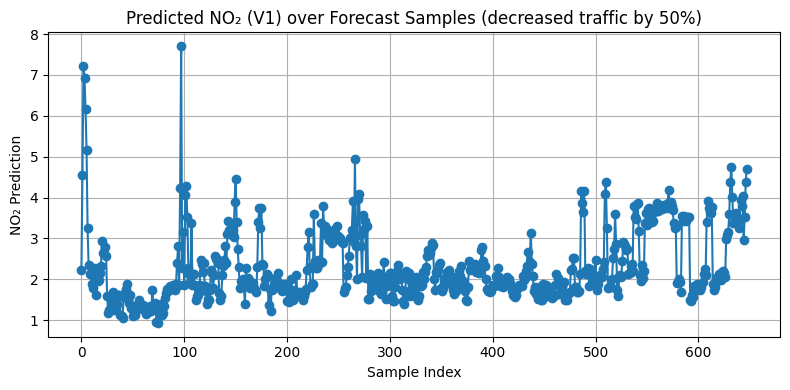

In [85]:
#Forecast with RF
preds_V2 = RF_best_model.predict(data3)
print(preds_V2)

plt.figure(figsize=(8,4))
plt.plot(preds_V2, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V1) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()


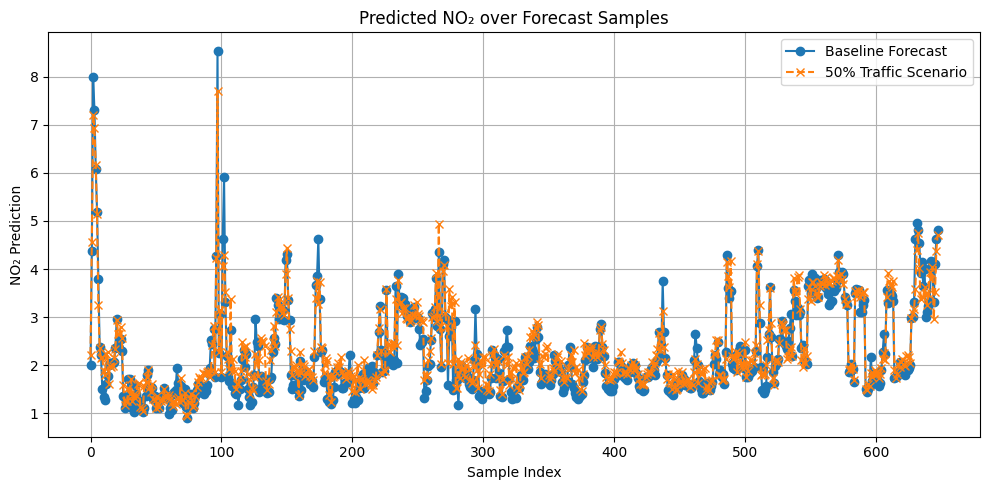

In [86]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Assume preds_V1 and preds_V2 are already in memory

plt.figure(figsize=(10,5))
plt.plot(preds_V1, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V2, marker='x', linestyle='--', label='50% Traffic Scenario')

plt.title("Predicted NO₂ over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()


In [ ]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v1 = preds_V1.mean()
avg_v2 = preds_V2.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (−50%)'],
    'Average NO₂': [avg_v1, avg_v2]
})

#Showing summary
df_summary


,Scenario,Average NO₂
0,Baseline Forecast,2.214837
1,50% Traffic (−50%),2.305678


### Forecast (decreased in Traffic North-East (Zone 12) and Traffic Hvidovre (Zone 17))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

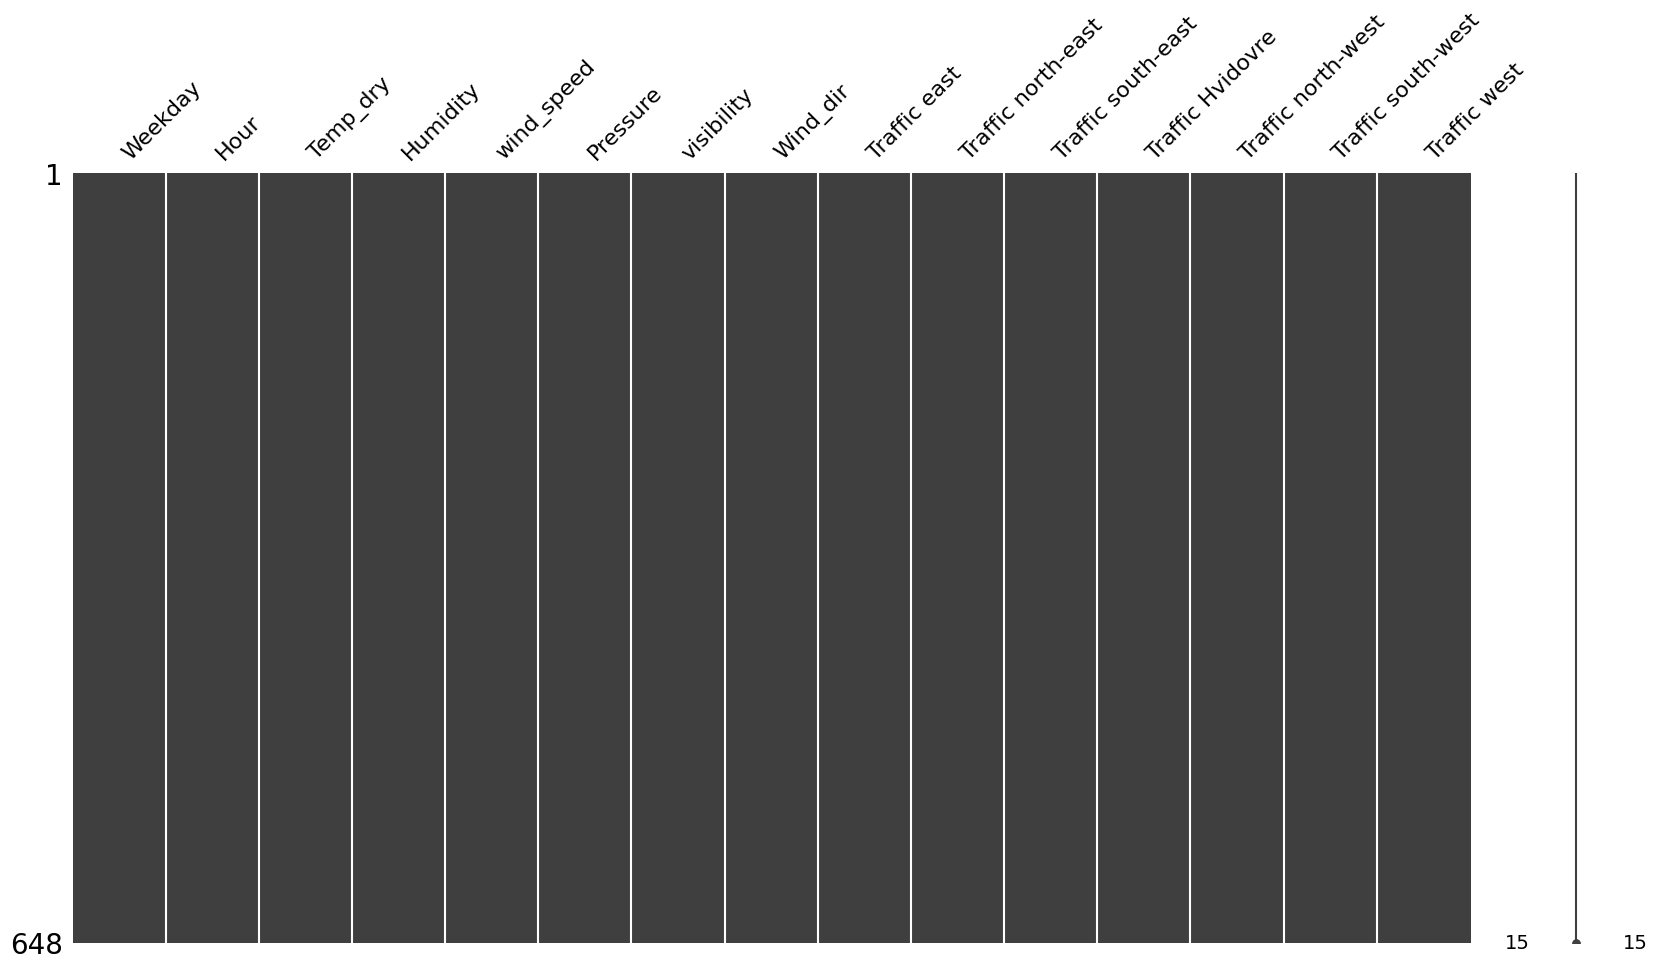

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      3.391251   
1      12.2        78         4.0    1021.9       21420      2.543438   
2      11.8        71         1.4    1021.9       12680      2.543438   
3      11.4        65         1.1    1022.1        4420      1.695626   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.423906            2.543438          1.271719   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1433392162.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data4['Temp_dry'].fillna(data4['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1433392162.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [96]:
#DATA PREP
import pandas as pd
# Load the data
data4 = pd.read_excel('../Combined data/Forecast May 2025 (decreased certain zones).xlsx')

data4 = data4.iloc[:, :9].join(data4[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data4.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data4.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data4.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data4['Weekday'] = data4['Weekday'].astype('category')
data4['Hour'] = data4['Hour'].astype('category')

print(data4.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data4['Wind_dir'] = pd.to_numeric(data4['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data4['Wind_dir'] = data4['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data4['Wind_dir'] = data4['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data4.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data4, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data4['Temp_dry'].fillna(data4['Temp_dry'].mean(), inplace=True)
data4['wind_speed'].fillna(data4['wind_speed'].mean(), inplace=True)
data4['Pressure'].fillna(data4['Pressure'].mean(), inplace=True)
data4['visibility'].fillna(data4['visibility'].mean(), inplace=True)
data4['Humidity'].fillna(data4['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data4.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data4 = pd.get_dummies(data4, drop_first=True)
print(data4.head())

[2.13808347 4.55450363 7.6592181  7.28619392 6.14599771 5.14401841
 3.61651304 2.45208317 2.22271849 2.28254117 2.02440567 2.22267895
 2.43385783 2.21300607 1.97398826 1.99403858 2.01126645 2.22795632
 2.33035004 2.33897228 2.7616255  2.24943256 2.32427208 2.61446645
 2.28856639 1.40691009 1.15235734 1.21994993 1.34099919 1.70561138
 1.83492619 1.70786815 1.18874953 1.49381403 1.80490799 1.64468839
 1.87312828 1.73218087 1.12913825 1.14125228 1.08767434 1.90418853
 1.6542515  1.62557263 1.85984518 1.44639213 1.35620764 1.52835462
 1.15022299 1.36382549 1.10036775 1.28846822 1.10909484 1.30221908
 1.3282459  1.34881477 1.51767547 1.2956362  1.37325939 1.36707915
 1.78895559 1.67420531 1.59990307 1.56799433 1.72086939 1.5411288
 1.84287417 1.60376033 1.35030486 1.53881745 1.22740166 1.19162167
 1.47849817 1.1190206  0.90825695 1.24113569 1.30958925 1.40068671
 1.11495257 1.21378371 1.35960388 1.45433822 1.58614259 1.9226083
 1.99760077 2.29714094 2.07832156 2.07240062 2.09481372 2.077204

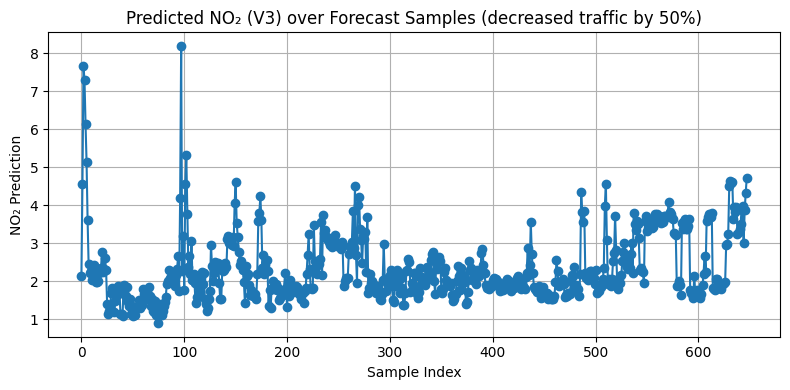

In [97]:
#Forecast with RF
preds_V3 = RF_best_model.predict(data4)
print(preds_V3)

plt.figure(figsize=(8,4))
plt.plot(preds_V3, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

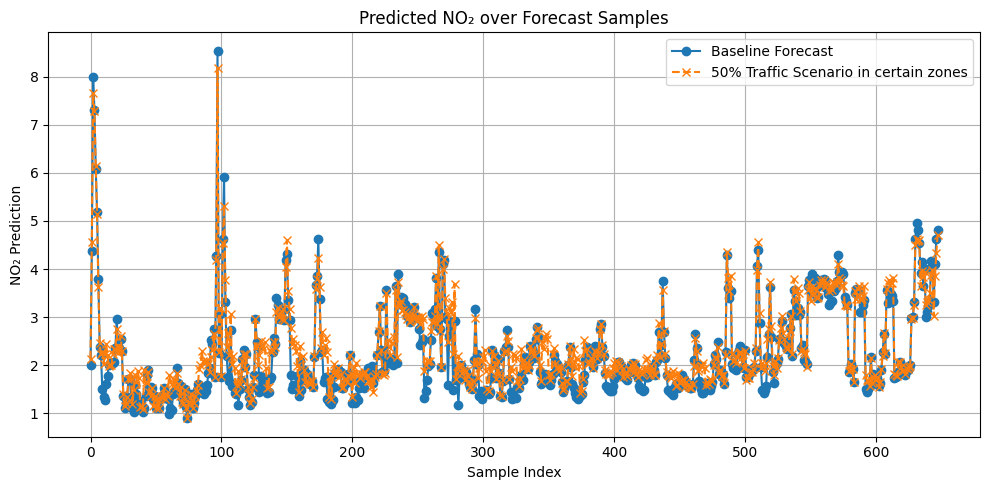

In [98]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Plotting V1 prediction with V3

plt.figure(figsize=(10,5))
plt.plot(preds_V1, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V3, marker='x', linestyle='--', label='50% Traffic Scenario in certain zones')

plt.title("Predicted NO₂ over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()


In [99]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v1 = preds_V1.mean()
avg_v3 = preds_V3.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (in certain zones)'],
    'Average NO₂': [avg_v1, avg_v3]
})

#Showing summary
df_summary


,Scenario,Average NO₂
0,Baseline Forecast,2.214837
1,50% Traffic (in certain zones),2.338360


### Forecast (decreased in Traffic East (Zone 11) and Traffic South-East (Zone 16))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

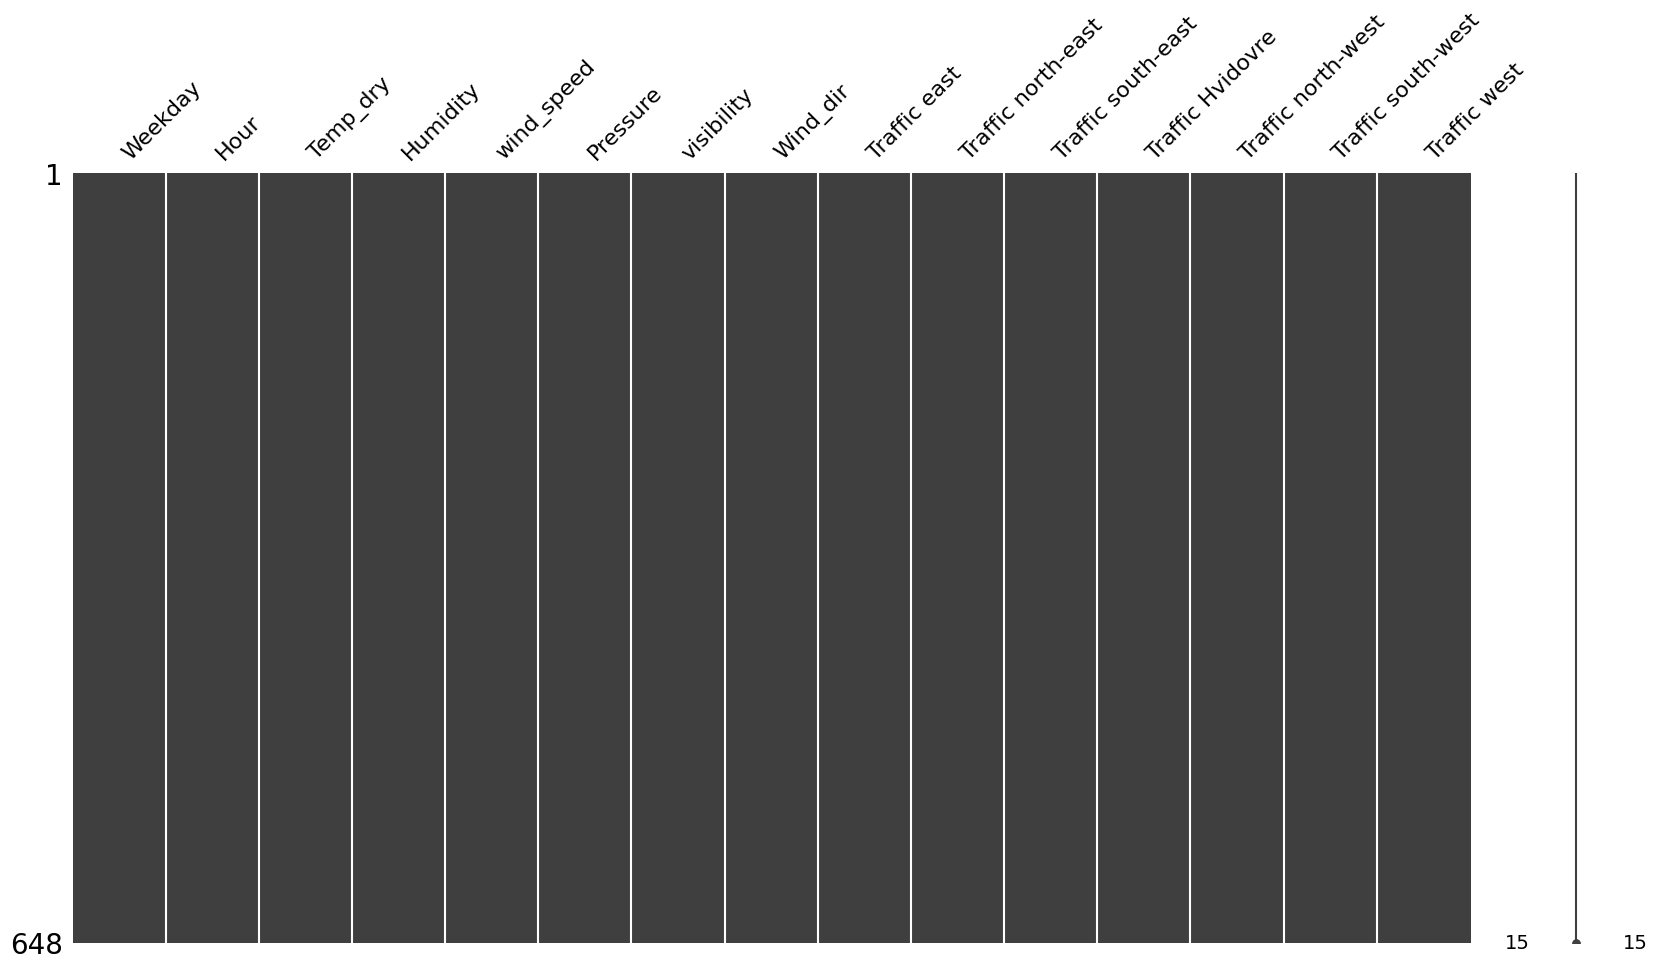

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      1.695626   
1      12.2        78         4.0    1021.9       21420      1.271719   
2      11.8        71         1.4    1021.9       12680      1.271719   
3      11.4        65         1.1    1022.1        4420      0.847813   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.847813            1.271719          2.543438   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\133329314.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data5['Temp_dry'].fillna(data5['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\133329314.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [103]:
#DATA PREP
import pandas as pd
# Load the data
data5 = pd.read_excel('../Combined data/Forecast May 2025 (decreased zone 11 and 16).xlsx')

data5 = data5.iloc[:, :9].join(data5[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data5.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data5.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data5.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data5['Weekday'] = data5['Weekday'].astype('category')
data5['Hour'] = data5['Hour'].astype('category')

print(data5.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data5['Wind_dir'] = pd.to_numeric(data5['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data5['Wind_dir'] = data5['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data5['Wind_dir'] = data5['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data5.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data5, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data5['Temp_dry'].fillna(data5['Temp_dry'].mean(), inplace=True)
data5['wind_speed'].fillna(data5['wind_speed'].mean(), inplace=True)
data5['Pressure'].fillna(data5['Pressure'].mean(), inplace=True)
data5['visibility'].fillna(data5['visibility'].mean(), inplace=True)
data5['Humidity'].fillna(data5['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data5.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data5 = pd.get_dummies(data5, drop_first=True)
print(data5.head())

[2.11074764 4.43567917 7.55414821 6.92921543 6.12083497 5.09348397
 3.67826721 2.3972548  2.1811639  1.85990342 1.63643886 1.39266552
 1.75334759 2.00315182 1.97724847 2.08118156 2.08762575 2.14541235
 2.1834704  2.39364574 2.92295098 2.41202646 2.45358387 2.59114622
 2.48777435 1.44900647 1.1256401  1.22032342 1.33024289 1.70881265
 1.61543329 1.58625364 1.53161808 1.20582966 1.64962008 1.52361123
 1.55218488 1.66570102 1.25586862 1.14662974 1.15473579 1.39428332
 1.38427458 1.83695247 1.88910646 1.51142285 1.47933903 1.58358635
 1.30899619 1.33428066 1.11131497 1.27341653 1.10963982 1.30221908
 1.30989166 1.37582454 1.50223049 1.51876676 1.32955695 1.34037573
 1.229869   1.23737645 1.16708461 1.31543701 1.44312484 1.53890569
 1.92839866 1.52395545 1.44228497 1.5804101  1.27836112 1.25137175
 1.43491708 1.09732412 0.90932655 1.2378608  1.29307707 1.40068671
 1.11495257 1.21077088 1.3757854  1.51462073 1.61344467 1.53775209
 1.48761407 1.49588734 1.43994642 1.40483276 1.47841866 1.6033

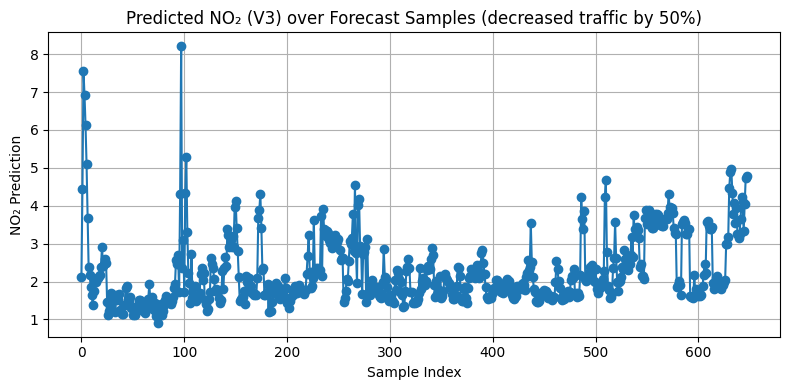

In [104]:
#Forecast with RF
preds_V4 = RF_best_model.predict(data5)
print(preds_V4)

plt.figure(figsize=(8,4))
plt.plot(preds_V4, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

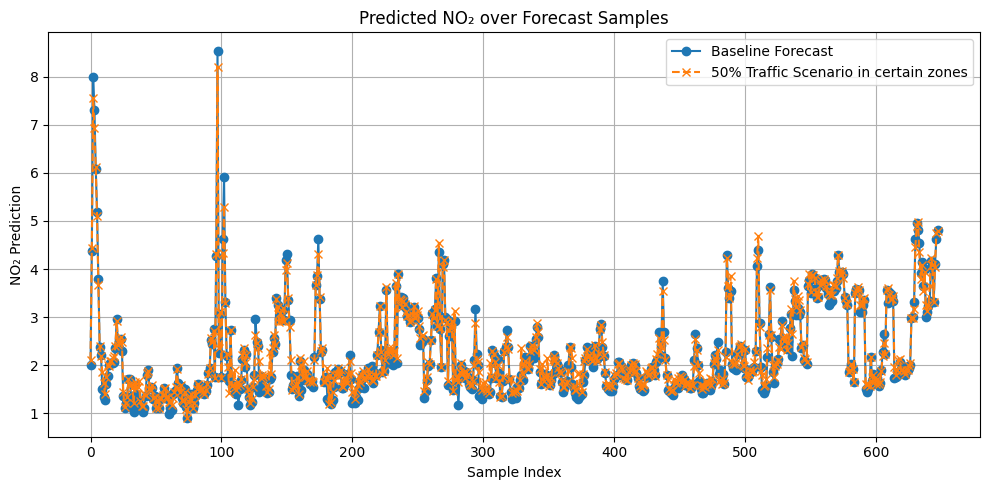

In [105]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Plotting V1 prediction with V4

plt.figure(figsize=(10,5))
plt.plot(preds_V1, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V4, marker='x', linestyle='--', label='50% Traffic Scenario in certain zones')

plt.title("Predicted NO₂ over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()

In [106]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v1 = preds_V1.mean()
avg_v4 = preds_V4.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (in certain zones)'],
    'Average NO₂': [avg_v1, avg_v4]
})

#Showing summary
df_summary


,Scenario,Average NO₂
0,Baseline Forecast,2.214837
1,50% Traffic (in certain zones),2.255501


##### Close to getting lower might be on to something with zone 11 and 16

### Forecast (decreased in Zone 11, 16 and 23)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

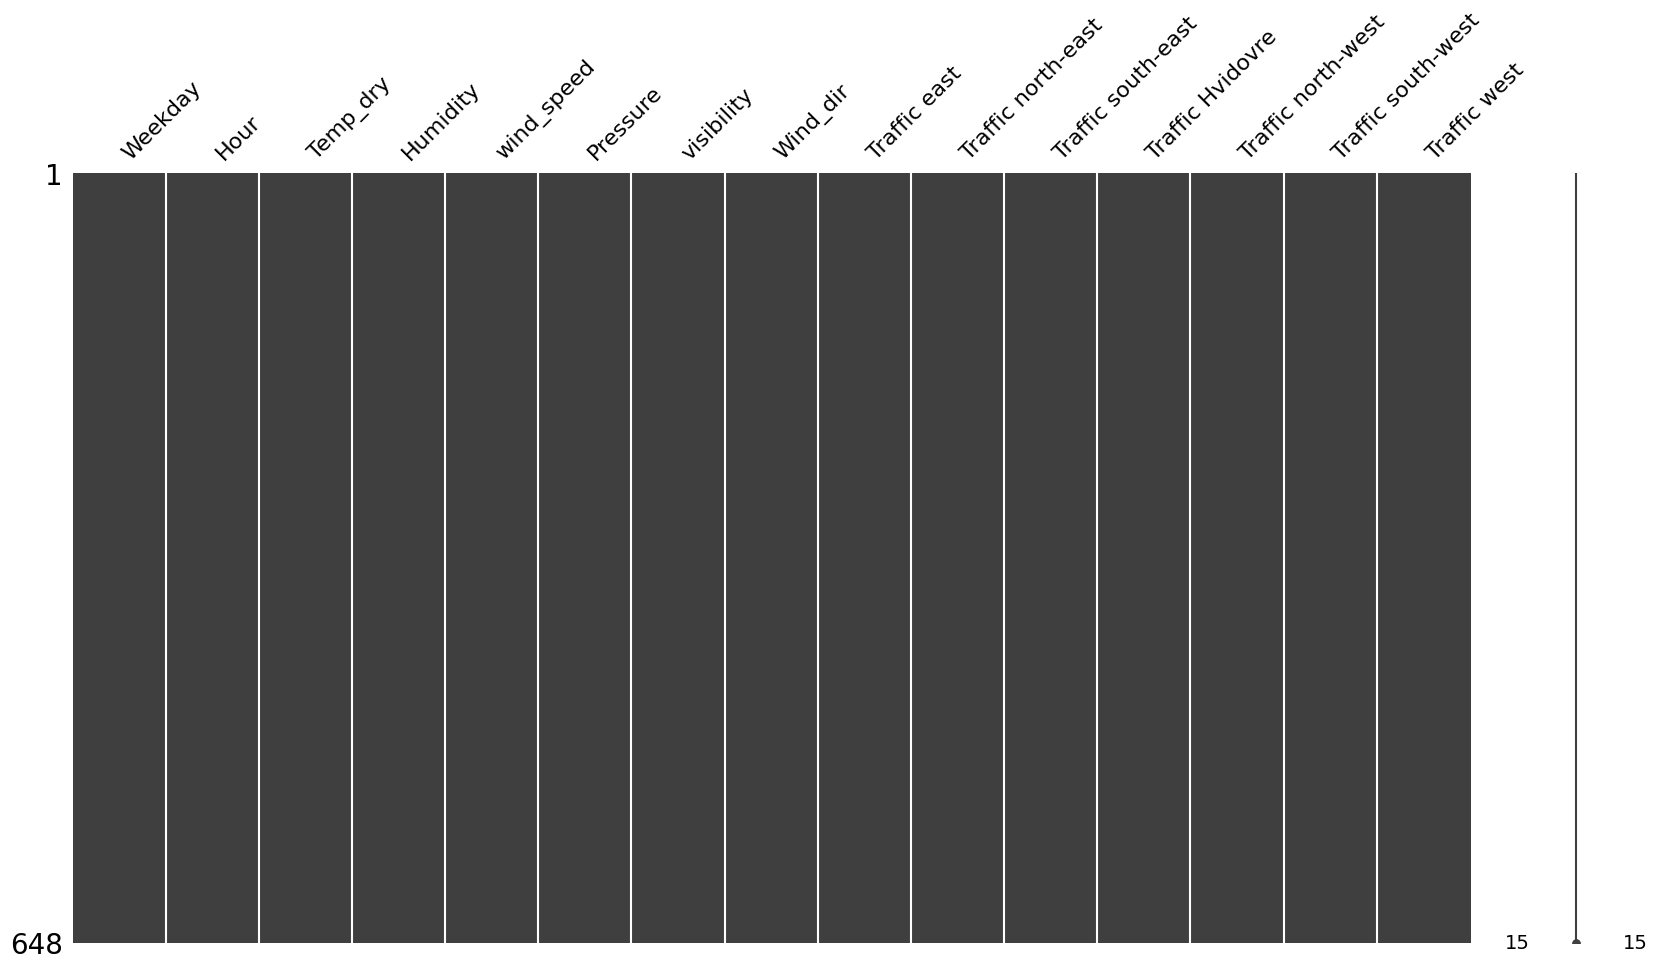

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      1.695626   
1      12.2        78         4.0    1021.9       21420      1.271719   
2      11.8        71         1.4    1021.9       12680      1.271719   
3      11.4        65         1.1    1022.1        4420      0.847813   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.847813            1.271719          2.543438   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\433269272.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data7['Temp_dry'].fillna(data7['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\433269272.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [120]:
#DATA PREP
import pandas as pd
# Load the data
data7 = pd.read_excel('../Combined data/Forecast May 2025 (decreased zone 11 16 and 23).xlsx')

data7 = data7.iloc[:, :9].join(data7[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data7.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data7.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
print(data7.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data7['Weekday'] = data7['Weekday'].astype('category')
data7['Hour'] = data7['Hour'].astype('category')

print(data7.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data7['Wind_dir'] = pd.to_numeric(data7['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data7['Wind_dir'] = data7['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data7['Wind_dir'] = data7['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data7.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data7, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data7['Temp_dry'].fillna(data7['Temp_dry'].mean(), inplace=True)
data7['wind_speed'].fillna(data7['wind_speed'].mean(), inplace=True)
data7['Pressure'].fillna(data7['Pressure'].mean(), inplace=True)
data7['visibility'].fillna(data7['visibility'].mean(), inplace=True)
data7['Humidity'].fillna(data7['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data7.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data7 = pd.get_dummies(data7, drop_first=True)
print(data7.head())

[2.20833579 4.43464067 7.8391372  7.26106761 6.24504966 5.30477082
 3.72098975 2.30591901 2.2176361  1.82281223 1.60760991 1.38725802
 1.75620283 2.0063813  1.92692548 2.05231824 2.06157962 2.11426103
 2.23744444 2.47198078 3.0676001  2.5791009  2.43654437 2.64956202
 2.52472506 1.54287469 1.18782122 1.29488683 1.29357571 1.66037792
 1.67676852 1.54121933 1.48256177 1.23357085 1.52100425 1.49559444
 1.56260354 1.67971684 1.23845384 1.13759448 1.13549064 1.42431975
 1.39525669 1.86585766 1.96520267 1.54531493 1.51688593 1.65862124
 1.42617953 1.33710882 1.18637662 1.3540673  1.11320929 1.31989405
 1.31482033 1.37890817 1.54219372 1.54198353 1.33411075 1.37149656
 1.25810826 1.26601351 1.19442294 1.31811641 1.44648679 1.51749623
 1.946688   1.510598   1.43171412 1.75318363 1.31208091 1.30683693
 1.45164851 1.12459873 0.90734619 1.21624154 1.29307707 1.40068671
 1.11495257 1.21077088 1.369552   1.55945053 1.67290834 1.58737334
 1.49553457 1.51583453 1.46875933 1.39632885 1.48156172 1.5869

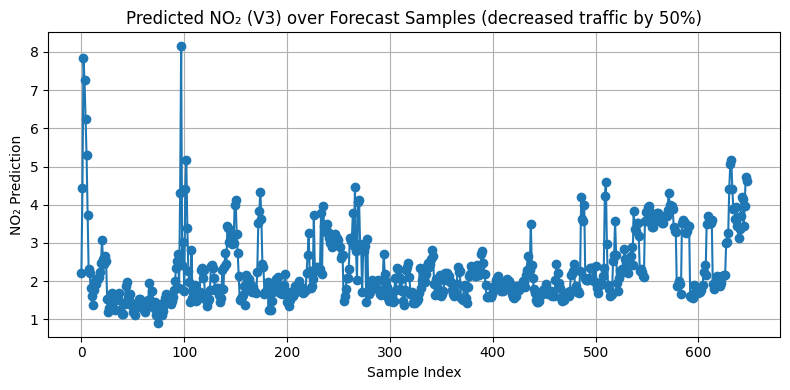

In [121]:
#Forecast with RF
preds_V5 = RF_best_model.predict(data7)
print(preds_V5)

plt.figure(figsize=(8,4))
plt.plot(preds_V5, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

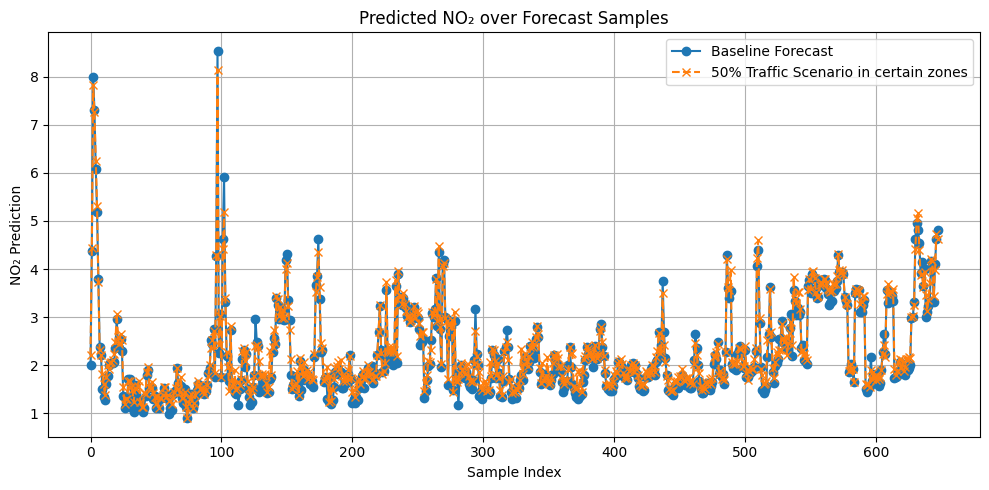

In [122]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Plotting V1 prediction with V4

plt.figure(figsize=(10,5))
plt.plot(preds_V1, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V5, marker='x', linestyle='--', label='50% Traffic Scenario in certain zones')

plt.title("Predicted NO₂ over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()

In [123]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v1 = preds_V1.mean()
avg_v5 = preds_V5.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (in certain zones)'],
    'Average NO₂': [avg_v1, avg_v5]
})

#Showing summary
df_summary

,Scenario,Average NO₂
0,Baseline Forecast,2.214837
1,50% Traffic (in certain zones),2.283709


### Script for halving specific zones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekday             648 non-null    object 
 1   Hour                648 non-null    int64  
 2   Temp_dry            648 non-null    float64
 3   Humidity            648 non-null    int64  
 4   wind_speed          648 non-null    float64
 5   Pressure            648 non-null    float64
 6   visibility          648 non-null    int64  
 7   Wind_dir            648 non-null    int64  
 8   Traffic east        648 non-null    float64
 9   Traffic north-east  648 non-null    float64
 10  Traffic south-east  648 non-null    float64
 11  Traffic Hvidovre    648 non-null    float64
 12  Traffic north-west  648 non-null    float64
 13  Traffic south-west  648 non-null    float64
 14  Traffic west        648 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 76.1+ K

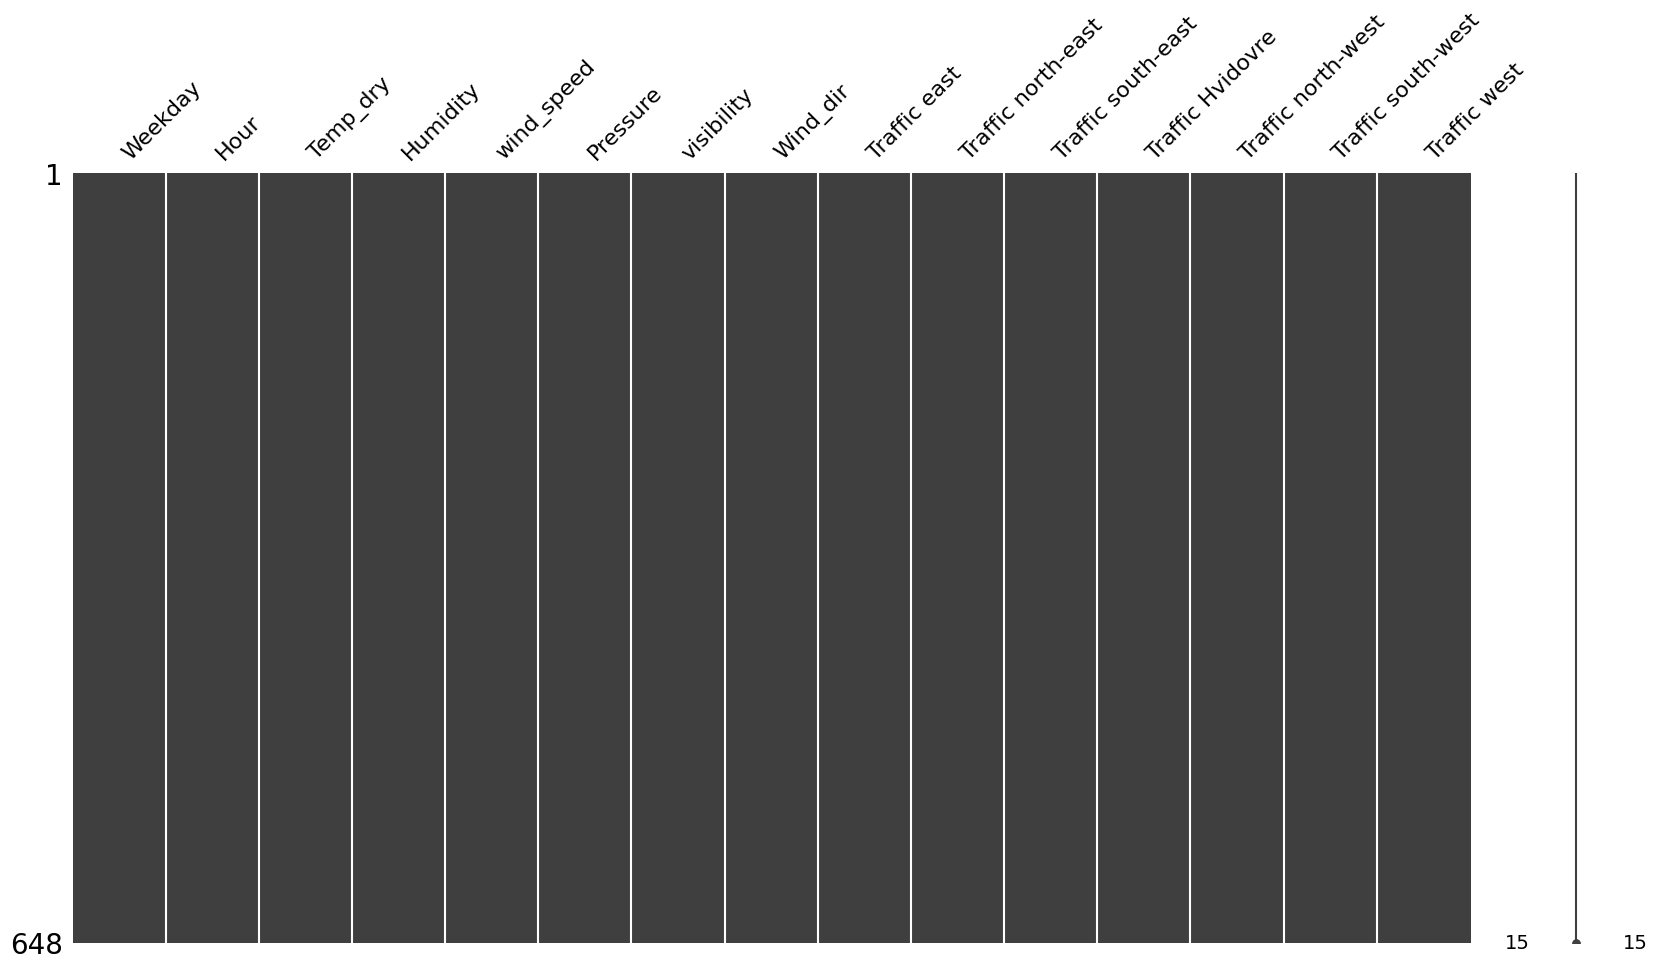

Data after dropping rows with missing values:
Weekday               0
Hour                  0
Temp_dry              0
Humidity              0
wind_speed            0
Pressure              0
visibility            0
Wind_dir              0
Traffic east          0
Traffic north-east    0
Traffic south-east    0
Traffic Hvidovre      0
Traffic north-west    0
Traffic south-west    0
Traffic west          0
dtype: int64
   Temp_dry  Humidity  wind_speed  Pressure  visibility  Traffic east  \
0      13.0        72         6.1    1021.5       26540      3.391251   
1      12.2        78         4.0    1021.9       21420      2.543438   
2      11.8        71         1.4    1021.9       12680      2.543438   
3      11.4        65         1.1    1022.1        4420      1.695626   
4      11.0        71         2.5    1021.9        1440      0.000000   

   Traffic north-east  Traffic south-east  Traffic Hvidovre  \
0            0.847813            1.271719          2.543438   
1            0.0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1524977986.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data8['Temp_dry'].fillna(data8['Temp_dry'].mean(), inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_37516\1524977986.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [164]:
#DATA PREP
import pandas as pd
# Load the data
data8 = pd.read_excel('../Combined data/Forecast May 2025.xlsx')

data8 = data8.iloc[:, :9].join(data8[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data8.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data8.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

zones_to_halve = [
    'Traffic south-east'    
]
data8[zones_to_halve] = data8[zones_to_halve] * 0.5

# Get the structure of the data
print(data8.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data8['Weekday'] = data8['Weekday'].astype('category')
data8['Hour'] = data8['Hour'].astype('category')

print(data8.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data8['Wind_dir'] = pd.to_numeric(data8['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data8['Wind_dir'] = data8['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data8['Wind_dir'] = data8['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
missing_values_count = data8.isnull().sum()
print("Missing values count in each column:")
print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data8, figsize=(20, 10))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data8['Temp_dry'].fillna(data8['Temp_dry'].mean(), inplace=True)
data8['wind_speed'].fillna(data8['wind_speed'].mean(), inplace=True)
data8['Pressure'].fillna(data8['Pressure'].mean(), inplace=True)
data8['visibility'].fillna(data8['visibility'].mean(), inplace=True)
data8['Humidity'].fillna(data8['Humidity'].mean(), inplace=True)
#data.dropna(inplace=True)

missing_values_count = data8.isnull().sum()
print("Data after dropping rows with missing values:")
print(missing_values_count)

# Transform the categorical variables into dummy variables
data8 = pd.get_dummies(data8, drop_first=True)
print(data8.head())

[1.98104106 4.40853844 7.84190429 7.19443426 6.12083497 5.12270497
 3.67958457 2.36997428 2.197075   1.55954943 1.375293   1.29846801
 1.64623784 1.70361429 1.96842914 2.04650879 2.06054014 2.00688594
 2.05125075 2.36416201 2.96003099 2.40655341 2.43078132 2.63286126
 2.42667542 1.39481816 1.10781489 1.20369771 1.33024289 1.71331309
 1.59508706 1.40765328 1.07561007 1.02548967 1.5960055  1.49070034
 1.26527338 1.19018228 1.20937029 1.09596713 1.10697862 1.13716811
 1.36220247 1.81466301 1.93764853 1.49791402 1.49478688 1.59174144
 1.28633353 1.36232826 1.10831169 1.28130501 1.10963982 1.30221908
 1.31543081 1.37606194 1.53100971 1.48908947 1.33826248 1.30753047
 1.09432051 1.14514065 1.09875055 1.36415448 1.56321734 1.59100665
 2.01222676 1.66716902 1.43546689 1.58023435 1.32015658 1.24664547
 1.4975339  1.11316971 0.88367009 1.2378608  1.29307707 1.40068671
 1.11495257 1.21338109 1.35687956 1.50924278 1.59363702 1.58935575
 1.52096562 1.51246278 1.45109053 1.41879829 1.49308547 1.6046

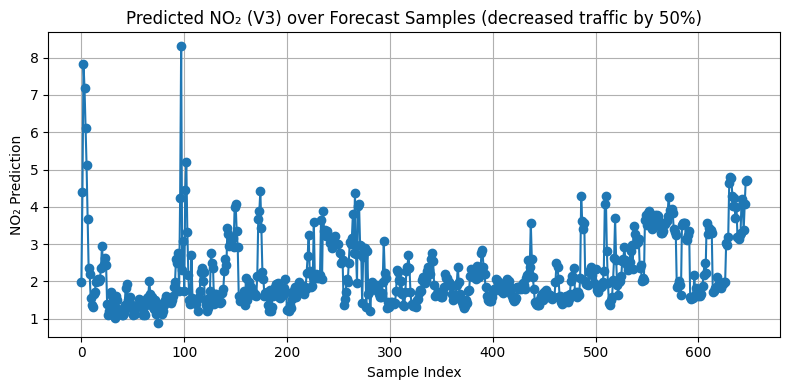

In [165]:
#Forecast with RF
preds_V6 = RF_best_model.predict(data8)
print(preds_V6)

plt.figure(figsize=(8,4))
plt.plot(preds_V6, marker='o', linestyle='-')
plt.title("Predicted NO₂ (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

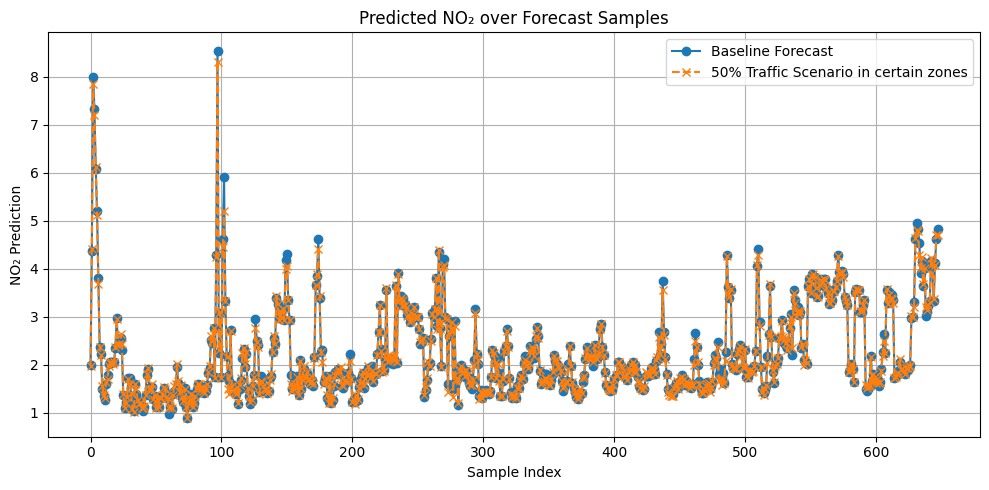

In [166]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Plotting V1 prediction with V4

plt.figure(figsize=(10,5))
plt.plot(preds_V1, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V6, marker='x', linestyle='--', label='50% Traffic Scenario in certain zones')

plt.title("Predicted NO₂ over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()

In [167]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v1 = preds_V1.mean()
avg_v6 = preds_V6.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (in certain zones)'],
    'Average NO₂': [avg_v1, avg_v6]
})

#Showing summary
df_summary

,Scenario,Average NO₂
0,Baseline Forecast,2.214837
1,50% Traffic (in certain zones),2.206661


### XGBOOST!!!

In [13]:
#Copyright Jonas Riis Vestergaard
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor  # or XGBClassifier for classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

all_predictions = []
all_actuals = []

for train_idx, val_idx in tscv.split(X_train):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
    model.fit(X_t, y_t)

    val_pred = model.predict(X_val)

    # Store results
    all_predictions.extend(val_pred)
    all_actuals.extend(y_val)

    mse_scores = mean_squared_error(y_val, val_pred)
    print(f"Fold MSE: {mean_squared_error(y_val, val_pred):.2f}")

# COMMENT BY SIMON: I believe the below code wrong, as it only prints the last fold of MSE. I have left it so you can inspect it. Use the other code (below that) instead (by William).
##########################################################
# Print average MSE
avg_mse = np.mean(mse_scores)
print(f"\nAverage MSE across folds: {avg_mse:.2f}")
##########################################################

# Average MSE across all predictions
from sklearn.metrics import mean_squared_error
avg_mse = mean_squared_error(all_actuals, all_predictions)
print(f"\nAverage MSE across folds: {avg_mse:.2f}")

Fold MSE: 15.30
Fold MSE: 35.46
Fold MSE: 8.84
Fold MSE: 15.04
Fold MSE: 4.91
Fold MSE: 8.83
Fold MSE: 5.01
Fold MSE: 3.41
Fold MSE: 2.35
Fold MSE: 4.74
Fold MSE: 5.65
Fold MSE: 6.32

Average MSE across folds: 6.32

Average MSE across folds: 9.65


### XGBOOST with Bayesian hyperparameter tuning

In [57]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
    # Parameters
    params = {
        "learning_rate":    trial.suggest_float("learning_rate", 0.005, 0.1),
        "max_depth":        trial.suggest_int("max_depth", 3, 15),  
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 25),
        "subsample":        trial.suggest_float("subsample", 0.3, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1),
        "gamma":            trial.suggest_float("gamma", 0.0, 1000.0),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0.0, 100.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 100.0),
        "objective":        "reg:squarederror",
        "random_state":     123,
        "n_jobs":           -1,
    }

    tscv = TimeSeriesSplit(n_splits=10)
    mses = []
    for train_idx, val_idx in tscv.split(X_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # move early_stopping_rounds here:
        model = xgb.XGBRegressor(**params,
                                 n_estimators=4000,
                                 early_stopping_rounds=50)
        model.fit(
            X_t, y_t,
            eval_set=[(X_v, y_v)],
            verbose=False
        )
        preds = model.predict(X_v)
        mses.append(mean_squared_error(y_v, preds))

    return np.mean(mses)


#Bayesian optimization
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=123)
)
study.optimize(objective, n_trials=1000)

print("Best params:", study.best_params)
print("Best CV MSE:", study.best_value)

#Optimal amount of trees (cross validated)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    params={**study.best_params, 
            "objective": "reg:squarederror",
            "random_state": 123,
            "n_jobs": -1},
    dtrain=dtrain,
    num_boost_round=10000,
    nfold=10,                   
    early_stopping_rounds=50,
    metrics="rmse",             
    seed=123,
    verbose_eval=False
)

best_nrounds = len(cv_results)
print("Optimal boosting rounds:", best_nrounds)


[I 2025-05-04 23:03:25,099] A new study created in memory with name: no-name-31a97760-182b-4ee9-b7df-4a10059e9d37
[I 2025-05-04 23:03:26,841] Trial 0 finished with value: 10.788910890802555 and parameters: {'learning_rate': 0.07116457263179686, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6859203383580239, 'colsample_bytree': 0.8036282788498941, 'gamma': 423.10646012446097, 'reg_lambda': 98.07641983846155, 'reg_alpha': 68.48297385848633}. Best is trial 0 with value: 10.788910890802555.
[I 2025-05-04 23:03:28,965] Trial 1 finished with value: 9.283428790879924 and parameters: {'learning_rate': 0.050688530641014286, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.8103347951688291, 'colsample_bytree': 0.607000571275737, 'gamma': 59.67789660956835, 'reg_lambda': 39.804425533043144, 'reg_alpha': 73.79954057320357}. Best is trial 1 with value: 9.283428790879924.
[I 2025-05-04 23:03:30,873] Trial 2 finished with value: 11.770016188316228 and parameters: {'learning_rate': 0.0223

Best params: {'learning_rate': 0.07558521288871195, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.31232874016652956, 'colsample_bytree': 0.7149851357536873, 'gamma': 19.584740803342818, 'reg_lambda': 63.205164268043404, 'reg_alpha': 0.21681149272655587}
Best CV MSE: 8.254505480360118
Optimal boosting rounds: 1157


In [ ]:
#Training final model
XGB_final = xgb.train(
    params={**study.best_params, "objective": "reg:squarederror"},
    dtrain=dtrain,
    num_boost_round=best_nrounds,
    verbose_eval=False
)

#DMatrix for test data
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = XGB_final.predict(dtest)

from sklearn.metrics import mean_squared_error
mse  = mean_squared_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")

#Feature importance plot for XGBoost
import matplotlib.pyplot as plt
ax = xgb.plot_importance(
    XGB_final,
    max_num_features=20,
    importance_type="gain",
    height=0.8
)
fig = ax.figure
fig.set_size_inches(10, 6)
plt.tight_layout()
plt.show()

Test MSE:  8.0854


In [ ]:
#Had some problems with installing optuna, if you also get this error (even though the requirements.txt works) then try running this.
import sys
!"{sys.executable}" -m pip install optuna==4.3.0

  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached sqlalchemy-2.0.40-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.2.1-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
Using cached alembic-1.15.2-py3-none-any.whl (231 kB)
Using cached sqlalchemy-2.0.40-cp312-cp312-win_amd64.whl (2.1 MB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached greenlet-3.2.1-cp312-cp312-win_amd64.whl (296 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Had some problems with installing optuna, if you also get this error (even though the requirements.txt works) then try running this.
import sys
!"{sys.executable}" -m pip install optuna==4.3.0

Visualizing the results

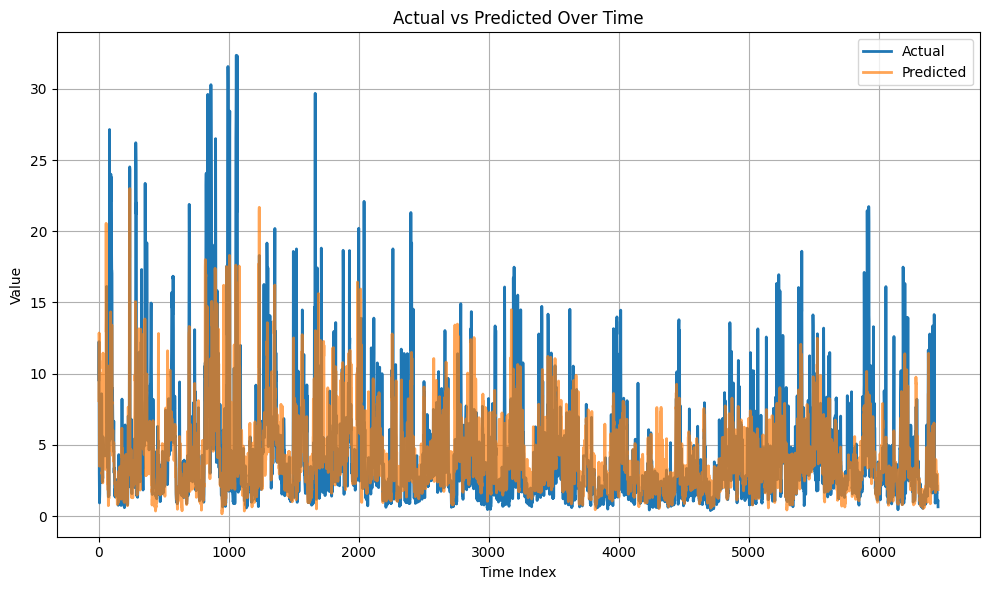


Actual vs Predicted:
      Actual  Predicted
0   9.571613   8.106401
1  12.250150  10.702187
2   4.387977  12.860296
3   3.054045  12.254664
4   1.247701   3.559229
5   0.924189   3.824902
6   1.209380   3.506981
7   1.578022   3.547015
8   3.228724   7.729162
9   5.306948   9.205032


In [ ]:
# Optional: convert to DataFrame for easy comparison
comparison_df = pd.DataFrame({
    "Actual": all_actuals,
    "Predicted": all_predictions
})

plt.figure(figsize=(10, 6))
plt.plot(comparison_df["Actual"], label="Actual", linewidth=2)
plt.plot(comparison_df["Predicted"], label="Predicted", linewidth=2, alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nActual vs Predicted:")
print(comparison_df.head(10))  # Print first 10 comparisons

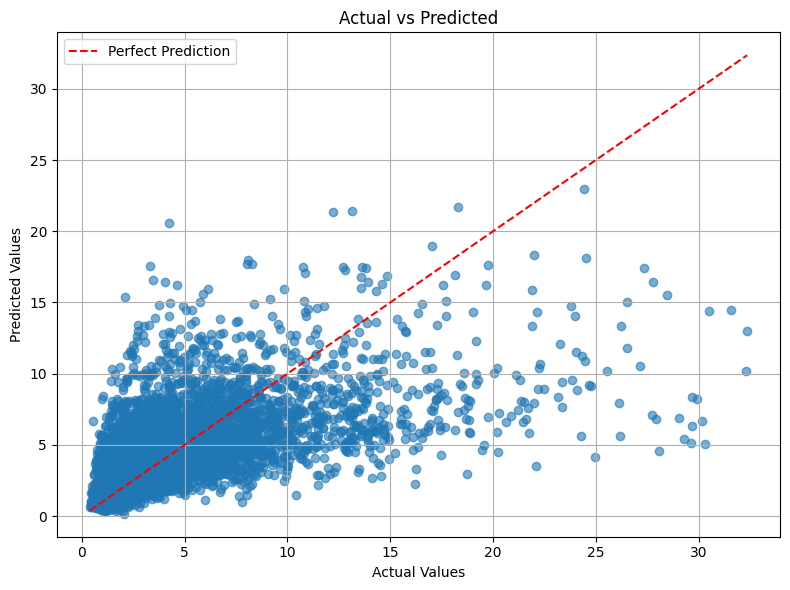

In [ ]:
# This plot could be deleted... shows the residuals
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df["Actual"], comparison_df["Predicted"], alpha=0.6)
plt.plot([comparison_df["Actual"].min(), comparison_df["Actual"].max()],
         [comparison_df["Actual"].min(), comparison_df["Actual"].max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Baseline to beat

The following is a baseline which always guesses the mean.

In [13]:
# Calculate the mean of the training target variable
baseline_prediction = y_train.mean()

# Predict the mean for the test set
y_baseline_pred = [baseline_prediction] * len(y_test)

# Evaluate the baseline model using Mean Squared Error
baseline_mse = mean_squared_error(y_test, y_baseline_pred)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 15.568077497911679


The MSE is at 15.6, which is significantly higher than our other models. Another baseline could be guessing the same NO2 value as the previous day.

Below is another baseline, which guesses the same NO2 level of the same hour from one day before.

In [15]:
# Create a new dataframe as a copy of the original data
naive_forecast_data = data.copy()

# Create a naive forecast by shifting the NO2_ppb column by 24 hours
naive_forecast_data['NO2_naive_forecast'] = naive_forecast_data['NO2_ppb'].shift(24)

# Drop rows with NaN values caused by the shift
naive_forecast_data = naive_forecast_data.dropna(subset=['NO2_naive_forecast'])

# Evaluate the naive forecast model using Mean Squared Error

naive_mse = mean_squared_error(naive_forecast_data['NO2_ppb'], naive_forecast_data['NO2_naive_forecast'])
print(f"Naive Forecast Mean Squared Error: {naive_mse}")

Naive Forecast Mean Squared Error: 21.797102656616282


## NOx --> dependent variable

Changed from NO2 to NOx as the dependent variable otherwise nothing has changed

### Random forest  model

In [31]:
import pandas as pd
# Load the data
data6 = pd.read_csv('../Combined data/combined_data_hourly_2023.csv')

data6 = data6.iloc[:, :11].join(data6[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data6.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data6.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
#print(data6.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data6['Weekday'] = data6['Weekday'].astype('category')
data6['Hour'] = data6['Hour'].astype('category')

#print(data6.head())

In [32]:
# Ensure the 'Wind_dir' column is numeric before categorization
data6['Wind_dir'] = pd.to_numeric(data6['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data6['Wind_dir'] = data6['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data6['Wind_dir'] = data6['Wind_dir'].astype('category')

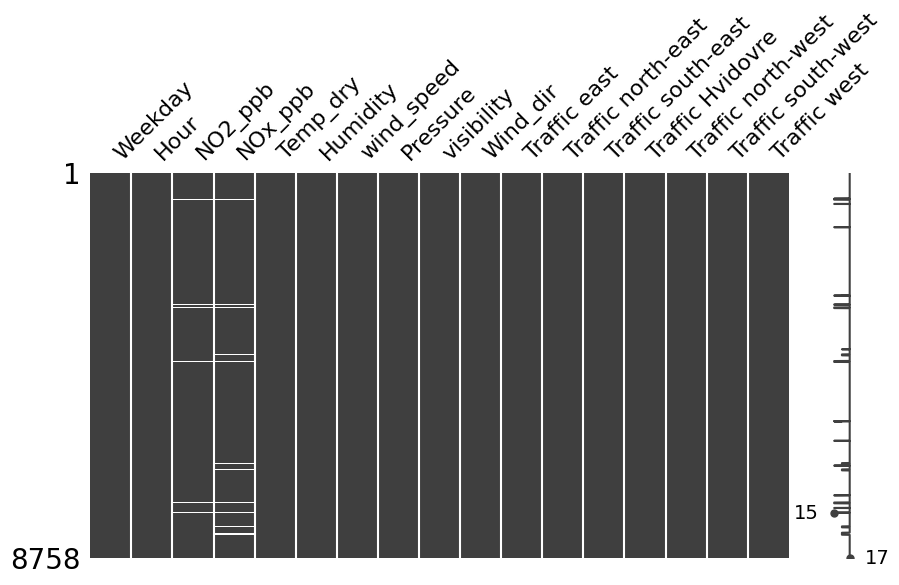

In [33]:
# Count rows with missing values
missing_values_count = data6.isnull().sum()
#print("Missing values count in each column:")
#print(missing_values_count)

# Visualize the missing data
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(data6, figsize=(10, 5))
plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data6.fillna({
    'NO2_ppb': data6['NO2_ppb'].mean(),
    'NOx_ppb': data6['NOx_ppb'].mean(),
    'Temp_dry': data6['Temp_dry'].mean(),
    'wind_speed': data6['wind_speed'].mean(),
    'Pressure': data6['Pressure'].mean(),
    'visibility': data6['visibility'].mean(),
    'Humidity': data6['Humidity'].mean()
}, inplace=True)
#data.dropna(inplace=True)

#missing_values_count = data6.isnull().sum()
#print("Data after dropping rows with missing values:")
#print(missing_values_count)

In [34]:
# Transform the categorical variables into dummy variables
data6 = pd.get_dummies(data6, drop_first=True)
#print(data6.head())

In [35]:
# X and Y. X should be all variables except NO2_ppb, and Y should be NO2_ppb
X2 = data6.drop(columns=['NO2_ppb', 'NOx_ppb'])
y2 = data6['NOx_ppb']

# Split the data into training and testing sets
split_index = int(len(X2) * 0.8)

# Chronological split, which is possible as the data is already in order
X_train2, X_test2 = X2.iloc[:split_index], X2.iloc[split_index:]
y_train2, y_test2 = y2.iloc[:split_index], y2.iloc[split_index:]

In [37]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, KFold

#*Note: The models are quite large due to the expansive grid search (Takes about 30 min to run ATM)

#Setting up training data
n_features2 = X_train2.shape[1]

#mtry grid
mtry_grid = [
    int(np.floor(n_features2 * p))
    for p in [0.05, 0.10, 0.15, 0.25, 0.30,
              0.35, 0.40, 0.45, 0.50, 0.55,
              0.60, 0.65, 0.70, 0.75, 0.80, 0.85]
]

#Rest of parameter grid
param_grid = {
    "max_features":   mtry_grid,
    "min_samples_leaf": list(range(1, 10)) #Can change this to keep it from fitting so much to the training data
}

#10-fold CV control (shuffled for extra randomness):
cv = KFold(n_splits=10, shuffle=True, random_state=123)

#There follows two models, just pick the one with the lowest CV validated MSE and test that model on the test set

# ——————————————
# A) “variance” splitrule → RandomForestRegressor
# ——————————————
rf2 = RandomForestRegressor(
    criterion="squared_error",
    random_state=123,
    n_jobs=-1
)
rf_search2 = GridSearchCV(
    rf2,
    param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
rf_search2.fit(X_train2, y_train2)

print("RF (variance) best params:", rf_search2.best_params_)
print("RF CV MSE:", -rf_search2.best_score_)

# ————————————————————
# B) “extratrees” splitrule → ExtraTreesRegressor
# ————————————————————
et = ExtraTreesRegressor(
    random_state=123,
    n_jobs=-1
)
et_search2 = GridSearchCV(
    et,
    param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)
et_search2.fit(X_train2, y_train2)

print("ET (extratrees) best params:", et_search2.best_params_)
print("ET CV MSE:", -et_search2.best_score_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
RF (variance) best params: {'max_features': 19, 'min_samples_leaf': 1}
RF CV MSE: 17.404734140265173
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
ET (extratrees) best params: {'max_features': 36, 'min_samples_leaf': 2}
ET CV MSE: 17.223328175907778


Random Forest Mean Squared Error: 34.509476324991866
Random Forest (extra trees) Mean Squared Error: 34.36165652702659


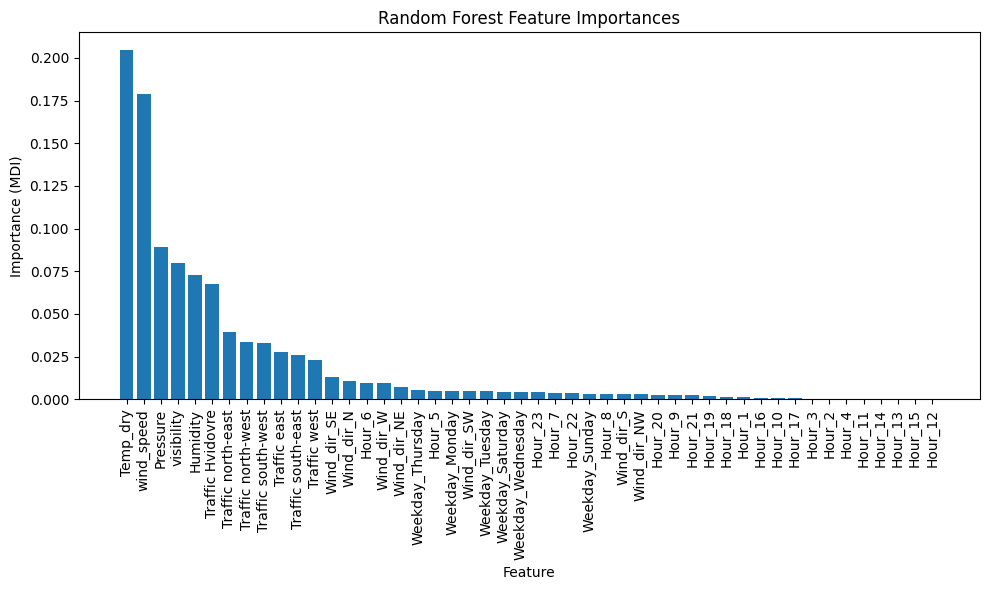

In [38]:
#Rf best
RF_best_model2 = rf_search2.best_estimator_
RF_pred2 = RF_best_model2.predict(X_test2)

RF_mse2 = mean_squared_error(y_test2, RF_pred2)
print(f"Random Forest Mean Squared Error: {RF_mse2}")

#ET best
ET_best_model2 = et_search2.best_estimator_
ET_pred2 = ET_best_model2.predict(X_test2)

ET_mse2 = mean_squared_error(y_test2, ET_pred2)
print(f"Random Forest (extra trees) Mean Squared Error: {ET_mse2}")

#Variable importance of the RF model
import numpy as np
import matplotlib.pyplot as plt

# Extract importances and feature names
importances = RF_best_model2.feature_importances_
feature_names = X_train2.columns 

# Sort by importance (descending)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features    = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(
    range(len(sorted_importances)),
    sorted_importances,
    align="center"
)
plt.xticks(
    range(len(sorted_importances)),
    sorted_features,
    rotation=90
)
plt.xlabel("Feature")
plt.ylabel("Importance (MDI)")
plt.tight_layout()
plt.show()

In [39]:
# Pickle the RF model
import pickle
with open('Models/RF_best_model2.pkl', 'wb') as f:
    pickle.dump(rf_search2.best_estimator_, f)
# Pickle the ET model
with open('Models/ET_best_model2.pkl', 'wb') as f:
    pickle.dump(et_search2.best_estimator_, f)

### Script for halving specific zones (for NOx)

### No change in traffic

In [40]:
#DATA PREP
import pandas as pd
# Load the data
data9 = pd.read_excel('../Combined data/Forecast May 2025.xlsx')

data9 = data9.iloc[:, :9].join(data9[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data9.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data9.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

# Get the structure of the data
#print(data9.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data9['Weekday'] = data9['Weekday'].astype('category')
data9['Hour'] = data9['Hour'].astype('category')

#print(data9.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data9['Wind_dir'] = pd.to_numeric(data9['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data9['Wind_dir'] = data9['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data9['Wind_dir'] = data9['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
#missing_values_count = data9.isnull().sum()
#print("Missing values count in each column:")
#print(missing_values_count)

# Visualize the missing data
#import missingno as msno
#import matplotlib.pyplot as plt

#msno.matrix(data9, figsize=(10, 5))
#plt.show()

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data9.fillna({
    'Temp_dry': data9['Temp_dry'].mean(),
    'wind_speed': data9['wind_speed'].mean(),
    'Pressure': data9['Pressure'].mean(),
    'visibility': data9['visibility'].mean(),
    'Humidity': data9['Humidity'].mean()
}, inplace=True)

#data.dropna(inplace=True)

#missing_values_count = data9.isnull().sum()
#print("Data after dropping rows with missing values:")
#print(missing_values_count)

# Transform the categorical variables into dummy variables
data9 = pd.get_dummies(data9, drop_first=True)

[3.26816074 6.10758286 9.37406851 8.84277759 5.94006138 6.37849402
 5.02069899 3.64686592 3.20683119 2.53190415 2.36769258 2.35178689
 3.17719344 3.30384784 3.37195342 3.04497817 3.30106118 3.21990085
 3.22444548 3.35365679 3.62698606 3.02935183 3.27803756 3.04390612
 2.67832798 1.29312792 1.32709122 1.38088592 1.61963873 2.35729274
 2.82689288 2.19915591 1.40915091 1.42568839 2.02284024 1.84706571
 1.76885417 1.6851621  1.62753669 1.40497516 1.32631566 1.59707106
 1.73839588 1.845052   2.01402396 1.47624062 1.32026571 1.80556935
 1.10818528 1.03319    0.91198507 1.85767808 0.9692697  1.20918287
 1.24109952 1.09401628 1.44626425 1.25094997 1.2383901  1.19694017
 1.13864507 1.12205213 1.13901803 1.29322621 1.32674035 1.68602682
 2.27166441 1.56905875 1.5890601  1.64223269 1.2779732  1.47813954
 1.06124767 0.81183042 0.81181187 0.88054823 1.06620459 1.31109451
 1.19602911 1.27643421 2.40772062 2.39087369 2.52626192 2.17661876
 2.11947043 2.01466838 2.07563527 2.02143756 2.15505172 2.3122

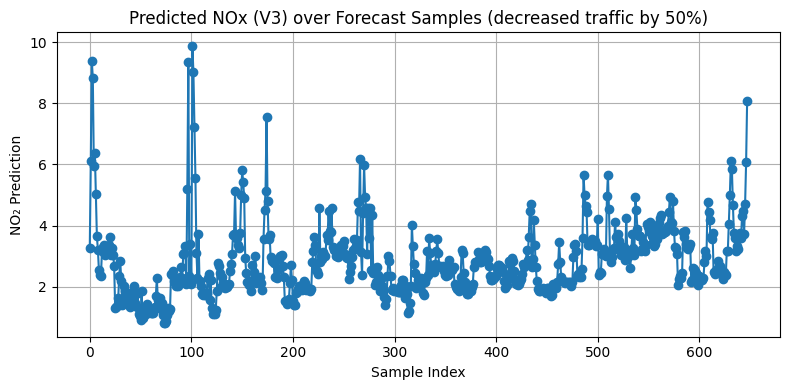

In [41]:
#Forecast with RF
preds_V7 = ET_best_model2.predict(data9)
print(preds_V7)

plt.figure(figsize=(8,4))
plt.plot(preds_V7, marker='o', linestyle='-')
plt.title("Predicted NOx (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NO₂ Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

### Change in traffic

In [43]:
#DATA PREP
import pandas as pd
# Load the data
data10 = pd.read_excel('../Combined data/Forecast May 2025.xlsx')

data10 = data10.iloc[:, :9].join(data10[['Celle 11', 'Celle 12', 'Celle 16', 'Celle 17', 'Celle 18', 'Celle 22', 'Celle 23']])

# Remove the date column
data10.drop(columns=['Date'], inplace=True)

# Rename columns to their relative position
data10.rename(columns={'Celle 11': 'Traffic east', 'Celle 12': 'Traffic north-east', 'Celle 18': 'Traffic north-west',
                     'Celle 17': 'Traffic Hvidovre', 'Celle 23': 'Traffic west', 'Celle 22': 'Traffic south-west',
                     'Celle 16': 'Traffic south-east'}, inplace=True)

zones_to_halve = [
    'Traffic south-east'    
]
data10[zones_to_halve] = data10[zones_to_halve] * 0.5

# Get the structure of the data
#print(data10.info())

# convert the 'Weekday' and 'Hour' Column to be categorical
data10['Weekday'] = data10['Weekday'].astype('category')
data10['Hour'] = data10['Hour'].astype('category')

#print(data10.head())

# Ensure the 'Wind_dir' column is numeric before categorization
data10['Wind_dir'] = pd.to_numeric(data10['Wind_dir'], errors='coerce')
# Partition the wind_dir into 8 categories
def categorize_wind_dir(wind_dir):
    if wind_dir < 22.5 or wind_dir >= 337.5:
        return 'N'
    elif 22.5 <= wind_dir < 67.5:
        return 'NE'
    elif 67.5 <= wind_dir < 112.5:
        return 'E'
    elif 112.5 <= wind_dir < 157.5:
        return 'SE'
    elif 157.5 <= wind_dir < 202.5:
        return 'S'
    elif 202.5 <= wind_dir < 247.5:
        return 'SW'
    elif 247.5 <= wind_dir < 292.5:
        return 'W'
    else:
        return 'NW'

# Apply the function to the 'Wind_dir' column
data10['Wind_dir'] = data10['Wind_dir'].apply(categorize_wind_dir)

# Convert the 'Wind_dir' column to categorical
data10['Wind_dir'] = data10['Wind_dir'].astype('category')


#MISSING DATA
# Count rows with missing values
#missing_values_count = data10.isnull().sum()
#print("Missing values count in each column:")
#print(missing_values_count)

# Impute the mean for missing values of numerical columns (the following code can be optimized)
data10.fillna({
    'Temp_dry': data10['Temp_dry'].mean(),
    'wind_speed': data10['wind_speed'].mean(),
    'Pressure': data10['Pressure'].mean(),
    'visibility': data10['visibility'].mean(),
    'Humidity': data10['Humidity'].mean()
}, inplace=True)

#data.dropna(inplace=True)

#missing_values_count = data10.isnull().sum()
#print("Data after dropping rows with missing values:")
#print(missing_values_count)

# Transform the categorical variables into dummy variables
data10 = pd.get_dummies(data10, drop_first=True)
#print(data10.head())

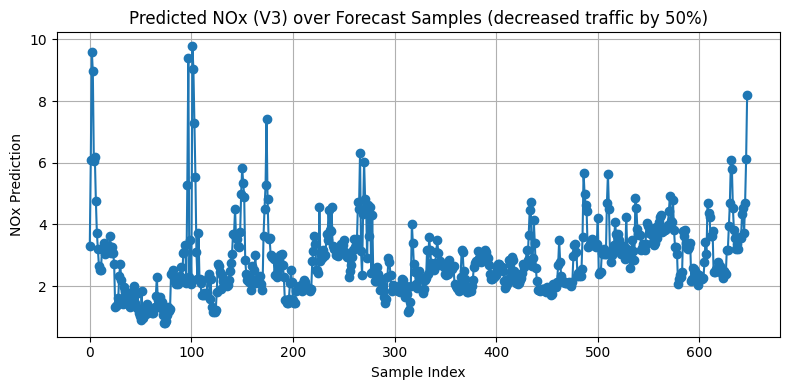

In [45]:
#Forecast with RF
preds_V8 = ET_best_model2.predict(data10)
#print(preds_V8)

plt.figure(figsize=(8,4))
plt.plot(preds_V8, marker='o', linestyle='-')
plt.title("Predicted NOx (V3) over Forecast Samples (decreased traffic by 50%)")
plt.xlabel("Sample Index")
plt.ylabel("NOx Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

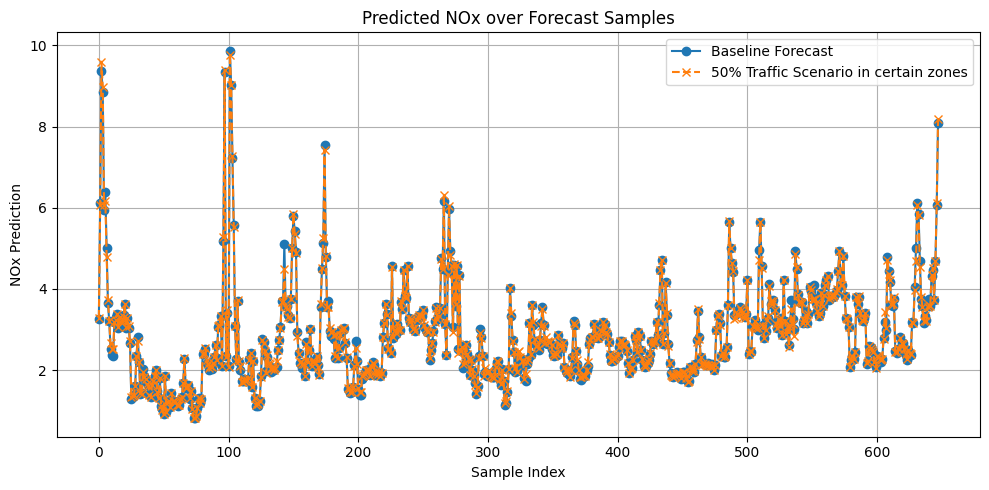

In [46]:
#Plotting both predictions on the same graph
import matplotlib.pyplot as plt

# Plotting V1 prediction with V4

plt.figure(figsize=(10,5))
plt.plot(preds_V7, marker='o', linestyle='-', label='Baseline Forecast')
plt.plot(preds_V8, marker='x', linestyle='--', label='50% Traffic Scenario in certain zones')

plt.title("Predicted NOx over Forecast Samples")
plt.xlabel("Sample Index")
plt.ylabel("NOx Prediction")
plt.grid(True)
plt.legend()             # <-- add legend for the two lines
plt.tight_layout()
plt.show()

In [47]:
#Table over the two predictions
import pandas as pd

# compute averages
avg_v7 = preds_V7.mean()
avg_v8 = preds_V8.mean()

# build a DataFrame
df_summary = pd.DataFrame({
    'Scenario': ['Baseline Forecast', '50% Traffic (in certain zones)'],
    'Average NOx': [avg_v7, avg_v8]
})

#Showing summary
df_summary

,Scenario,Average NOx
0,Baseline Forecast,2.829418
1,50% Traffic (in certain zones),2.830340


### Baseline for NOx

In [49]:
# Find the RMSE of the predictions if only the mean is guessed 
import numpy as np
from sklearn.metrics import mean_squared_error
# Calculate the mean of the training target variable
baseline_prediction = y_train2.mean()
# Predict the mean for the test set
y_baseline_pred = [baseline_prediction] * len(y_test2)
# Evaluate the baseline model using Mean Squared Error
baseline_mse = mean_squared_error(y_test2, y_baseline_pred)
print(f"Baseline Mean Squared Error (NOx): {baseline_mse}")
print(f"Baseline Root Mean Squared Error (NOx): {baseline_mse**0.5}")


Baseline Mean Squared Error (NOx): 53.831177631294636
Baseline Root Mean Squared Error (NOx): 7.33697332905706
